<a href="https://colab.research.google.com/github/daniel-muthukrishna/transomaly/blob/master/anomaly_detection_probabilistic_mcdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
! pip install astrorapid
! pip install celerite
! pip install keras-tcn
# ! pip install tensorflow-gpu

In [3]:
% cd /content/gdrive/My Drive/Projects/transomaly

/content/gdrive/My Drive/Projects/transomaly


In [4]:
import os
import numpy as np
import h5py
import pickle
import copy

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Masking, Input, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

from tcn import TCN, tcn_full_summary
# from bayesian_tcn import TCN, tcn_full_summary

import astrorapid

from transomaly.prepare_training_set import PrepareTrainingSetArrays
from transomaly.loss_functions import mean_squared_error, chisquare_loss, mean_squared_error_over_error, negloglike, negloglike_with_error
from transomaly.plot_metrics import plot_history  # , plot_metrics

You will need to install 'emcee' if you wish to train your own classifier on new data.


Using TensorFlow backend.


In [5]:
COLPB = {'g': 'tab:blue', 'r': 'tab:red', 'gpred': 'turquoise', 'rpred': 'tab:pink'}
MARKPB = {'g': 'o', 'r': 's', 'z': 'd'}
ALPHAPB = {'g': 0.3, 'r': 1., 'z': 1}
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
from astropy.stats import median_absolute_deviation

from transomaly.fit_gaussian_processes import save_gps
from astrorapid.get_training_data import get_data
from transomaly import helpers

def plot_history(history, model_filename):
    # Plot loss vs epochs
    plt.figure()
    trainloss = history.history['loss']
    valloss = history.history['val_loss']
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(model_filename.replace('.hdf5', '.pdf'))
    #Plot zoomed y axis figure
    plt.figure()
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(bottom=min(valloss)-abs(0.1*min(valloss)), top=1.1*max(np.array(valloss)[abs(valloss-np.median(valloss)) < 5 * median_absolute_deviation(valloss)]))
    plt.savefig(f"{model_filename.replace('.hdf5', '_zoomed0.pdf')}")
    # Plot zoomed figure
    lenloss = len(trainloss)
    zoomloss = int(lenloss / 2.)
    plt.figure()
    plt.plot(np.arange(zoomloss, lenloss), trainloss[zoomloss:])
    plt.plot(np.arange(zoomloss, lenloss), valloss[zoomloss:])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(bottom=min(valloss)-abs(0.1*min(valloss)), top=1.1*max(np.array(valloss[zoomloss:])[abs(valloss[zoomloss:]-np.median(valloss[zoomloss:])) < 5 * median_absolute_deviation(valloss[zoomloss:])]))
    plt.savefig(f"{model_filename.replace('.hdf5', '_zoomed.pdf')}")
    # Plot zoomed figure reduced y axis
    lenloss = len(trainloss)
    zoomloss = int(0.75*lenloss)
    plt.figure()
    plt.plot(np.arange(zoomloss, lenloss), trainloss[zoomloss:])
    plt.plot(np.arange(zoomloss, lenloss), valloss[zoomloss:])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.ylim(bottom=min(valloss)-abs(0.1*min(valloss)), top=1.1*max(np.array(valloss[zoomloss:])[abs(valloss[zoomloss:]-np.median(valloss[zoomloss:])) < 5 * median_absolute_deviation(valloss[zoomloss:])]))
    plt.savefig(f"{model_filename.replace('.hdf5', '_zoomed2.pdf')}")


def plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands, fig_dir, nsamples, data_dir,  save_dir, nprocesses, plot_gp=False, extrapolate_gp=True, reframe=False, plot_name='', npred=49, probabilistic=False, known_redshift=False, get_data_func=None, normalise=False, bayesian=False, model_num=None):
    print(model_name)
    nobjects, ntimesteps, nfeatures = X_test.shape
    npassbands = len(passbands)
    sntypes_map = helpers.get_sntypes()

    sampled_ypred = []
    sampled_ystd = []
    draws = []
    if probabilistic:
        X_test = np.asarray(X_test, np.float32)
        y_test = np.asarray(y_test, np.float32)
        # yhat = model(X_test)
        # y_pred = np.asarray(yhat.mean())
        # y_pred_std = np.asarray(yhat.stddev())
        if bayesian:
            ns = 100
            for i in range(ns):
                sampled_yhat = model(X_test)
                sampled_ypred.append(np.asarray(sampled_yhat.mean()))
                sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
                draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
            # plot_mean_ypred = np.mean(np.array(sampled_ypred), axis=0)
            # plot_sigma_ypred = np.std(np.array(sampled_ypred), axis=0)
            plot_mean_ypred = np.mean(np.array(draws), axis=0)
            plot_sigma_ypred = np.std(np.array(draws), axis=0)
        else:
            yhat = model(X_test)
            plot_mean_ypred = np.asarray(yhat.mean())
            plot_sigma_ypred = np.asarray(yhat.stddev())
    else:
        y_pred = model.predict(X_test)

    if not reframe:
        npred = ntimesteps

    # Get raw light curve data
    light_curves = {}
    gp_fits = {}
    for classnum in np.unique(labels_test):
        print(f"Getting lightcurves for class:{classnum}")
        light_curves[classnum] = get_data(get_data_func=get_data_func, class_num=classnum, data_dir=data_dir,
                                          save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                          nprocesses=nprocesses, redo=False, calculate_t0=False)
        if plot_gp is True and nsamples == 1:
            gp_fits[classnum] = save_gps(light_curves, save_dir, classnum, passbands, plot=False,
                                     nprocesses=nprocesses, redo=False, extrapolate=extrapolate_gp)

    # # Plot predictions vs time per class
    # font = {'family': 'normal',
    #         'size': 36}
    # matplotlib.rc('font', **font)

    # # Example transients for paper
    # # import pdb; pdb.set_trace()
    # ylims_paper_objids = {'1_132490785': (-300, 2400), '2_113673268': (-350, 1100), '3_125078236': (-600, 1700), '51_107222452': (-350, 1200), '60_39476620': (-400, 2400), '64_31366754': (-150, 800)}  # '51_107222452': (-3, 1200)
    # for paper_objid in ['1_132490785', '2_113673268', '3_125078236', '51_107222452', '60_39476620', '64_31366754']:
    #     try:
    #         paper_idx = int(np.where(objids_test == paper_objid)[0])
    #     except TypeError:
    #         continue
    #     print(paper_idx, paper_objid)
    #     cnum = int(paper_objid.split('_')[0])
    #     cname = sntypes_map[cnum]
    #     lc = light_curves[cnum][paper_objid]

    #     # fig, (ax1) = plt.subplots(nrows=1, ncols=1) #1
    #     fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.2, 6), sharex=True) #2
    #     for pbidx, pb in enumerate(passbands):
    #         pbmask = lc['passband'] == pb
    #         ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data, fmt='.', color=COLPB[pb], label=f'${pb}$-band obs')
    #         # ax1.errorbar(timesX_test[paper_idx][1:][-npred:], y_test[paper_idx][:, pbidx], yerr=yerr_test[paper_idx][:, pbidx], label=f'${pb}$ band interp data', fmt='.', linestyle='-', color='cyan')
    #         for drawidx in range(ns):
    #             ax1.plot(timesX_test[paper_idx][1:][-npred:], sampled_ypred[drawidx][paper_idx][:, pbidx], color=COLPB[pb], alpha=0.05)
    #         ax1.plot(timesX_test[paper_idx][1:][-npred:], np.median(np.array(sampled_ypred)[:, paper_idx, :, pbidx], axis=0), label=f'${pb}$-band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median
    #         # ax1.errorbar(timesX_test[paper_idx][1:][-npred:], plot_mean_ypred[paper_idx][:, pbidx], yerr=plot_sigma_ypred[paper_idx][:, pbidx], color='pink', label=f'${pb}$ band pred mean')
    #     ax1.tick_params(axis='x', labelsize=15)
    #     ax1.tick_params(axis='y', labelsize=15)
    #     ax2.tick_params(axis='x', labelsize=15) #2
    #     ax2.tick_params(axis='y', labelsize=15) #2
    #     plt.xlim(max(-67, min(lc[pbmask]['time'].data)), min(77, max(timesX_test[paper_idx][1:][-npred:])))
    #     ax1.set_ylim(*ylims_paper_objids[paper_objid])
    #     chi2 = 0
    #     negloglike = 0
    #     maskzeros = True
    #     maskzeros_pb = {}
    #     mask_npb = 0
    #     for pbidx in range(npassbands):
    #         yt = y_test[paper_idx, :, pbidx]
    #         yterr = yerr_test[paper_idx, :, pbidx]
    #         yp = plot_mean_ypred[paper_idx, :, pbidx]
    #         yperr = plot_sigma_ypred[paper_idx, :, pbidx]
    #         maskzeros_pb[pb] = ((yterr != 0) * (np.isfinite(yterr)))
    #         mask_npb = maskzeros_pb[pb] + mask_npb
    #         maskzeros = maskzeros_pb[pb] & maskzeros
    #         chi2_pb = ((yp - yt)/yterr)**2
    #         chi2_pb[~np.isfinite(chi2_pb)] = 0
    #         chi2 += chi2_pb
    #         negloglike_pb = 0.5 * (yp - yt)**2 / (yterr*2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
    #         negloglike_pb[~np.isfinite(negloglike_pb)] = 0
    #         negloglike += negloglike_pb
    #     chi2 = chi2 / mask_npb
    #     chi2cumsum = np.cumsum(chi2)/np.arange(1, len(chi2)+1)
    #     negloglike = negloglike / mask_npb
    #     negloglikecumsum = np.cumsum(negloglike)/np.arange(1, len(negloglike)+1)
    #     # ax1.text(0.05, 0.95, f"$\chi^2 = {round(max(chi2), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure) #1
    #     # ax1.text(0.05, 0.95, f"{class_name}", transform=fig.transFigure) #1
    #     ax1.set_ylabel("Relative flux", fontsize=15)
    #     # ax1.set_xlabel("Time since trigger [days]", fontsize=15) #1
    #     ax2.set_xlabel("Time since trigger [days]", fontsize=15) #2
    #     ax2.set_ylabel("Anomaly score", fontsize=15) #2
    #     # ax1.legend(frameon=True, fontsize=13, loc='upper left')
    #     ax2.plot(timesX_test[paper_idx][1:][-npred:], negloglikecumsum, lw=2) #2
    #     # ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(chi2)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes) #2
    #     plt.tight_layout()
    #     fig.subplots_adjust(hspace=0) #2
    #     # plt.savefig(f"DNN_model-{classnum}_fitting-{paper_objid}.png") #1
    #     plt.savefig(f"DNN_model-{model_num}_fitting-{paper_objid}_withanomalyplot.pdf") #2
    #     plt.show()
    #     plt.close()

    #Plot example lightcurves and anomaly scores
    for idx in np.arange(0, 10):
        sidx = idx * nsamples  # Assumes like samples are in order
        print("Plotting example vs time", idx, objids_test[sidx])
        argmax = None  #timesX_test[sidx].argmax()  # -1

        # Get raw light curve observations
        lc = light_curves[labels_test[sidx]][objids_test[sidx]]
        if plot_gp is True and nsamples == 1:
            gp_lc = gp_fits[labels_test[sidx]][objids_test[sidx]]

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5.2, 6), sharex=True)

        for pbidx, pb in enumerate(passbands):
            pbmask = lc['passband'] == pb

            for s in range(1):#nsamples):
                lw = 1 if s == 0 else 0.1
                alpha = 1 if s == 0 else 0.1
                plotlabeltest = "ytest:{}".format(pb) if s == 0 else ''
                plotlabelpred = "ypred:{}".format(pb) if s == 0 else ''
                marker = None  # MARKPB[pb] if s == 0 else None
                if reframe:
                    ax1.plot(timesX_test[sidx + s][:-1][:argmax], X_test[sidx + s][:, pbidx][:-1][:argmax], c=COLPB[pb], lw=lw,
                             label=plotlabeltest, marker=marker, markersize=3, alpha=alpha, linestyle='-')
                ax1.errorbar(timesX_test[sidx+s][1:][-npred:][:argmax], y_test[sidx+s][:, pbidx][:argmax], yerr=yerr_test[sidx+s][:, pbidx][:argmax], c=COLPB[pb], lw=lw,
                         label=plotlabeltest, marker='o', markersize=3, alpha=alpha, linestyle='-')
                if probabilistic:
                    if bayesian:
                        for sp in range(ns):
                            ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], sampled_ypred[sp][sidx + s][:, pbidx][:argmax], yerr=sampled_ystd[sp][sidx + s][:, pbidx][:argmax],
                                    color=COLPB[f'{pb}pred'], lw=0.1, marker='*', markersize=3, alpha=1/256, linestyle=':')
                    ax1.errorbar(timesX_test[sidx + s][1:][-npred:][:argmax], plot_mean_ypred[sidx + s][:, pbidx][:argmax], yerr=plot_sigma_ypred[sidx + s][:, pbidx][:argmax],
                            color=COLPB[f'{pb}pred'], lw=lw, label=plotlabelpred, marker='x', markersize=5, alpha=1, linestyle=':')
  
                else:
                    ax1.plot(timesX_test[sidx+s][1:][-npred:][:argmax], y_pred[sidx+s][:, pbidx][:argmax], c=COLPB[f'{pb}pred'], lw=lw,
                             label=plotlabelpred, marker='*', markersize=3, alpha=alpha, linestyle=':')

            if not normalise:
                ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data,
                            fmt="x", capsize=0, color=COLPB[pb], label='_nolegend_', markersize=3, )

                if plot_gp is True and nsamples == 1:
                    gp_lc[pb].compute(lc[pbmask]['time'].data, lc[pbmask]['fluxErr'].data)
                    pred_mean, pred_var = gp_lc[pb].predict(lc[pbmask]['flux'].data, timesX_test[sidx + s][:argmax],
                                                            return_var=True)
                    pred_std = np.sqrt(pred_var)
                    ax1.fill_between(timesX_test[sidx + s][:argmax], pred_mean + pred_std, pred_mean - pred_std, color=COLPB[pb],
                                    alpha=0.05,
                                    edgecolor="none")
                # ax1.text(0.05, 0.95, f"$\chi^2 = {round(save_chi2[objids_test[idx]], 3)}$", horizontalalignment='left',
                #          verticalalignment='center', transform=ax1.transAxes)
                # plt.xlim(-70, 80)

        # Plot anomaly scores
        chi2_samples = []
        like_samples = []
        negloglike_samples = []
        for s in range(1):#nsamples):
            chi2 = 0
            like = 0
            negloglike = 0
            for pbidx in range(npassbands):
                m = yerr_test[sidx+s, :, pbidx][:argmax] != 0  # ignore zeros (where no data exists)
                yt = y_test[sidx+s, :, pbidx][:argmax][m]
                yterr = yerr_test[sidx+s, :, pbidx][:argmax][m]
                yp = plot_mean_ypred[sidx+s, :, pbidx][:argmax][m]
                yperr = plot_sigma_ypred[sidx+s, :, pbidx][:argmax][m]
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                    negloglike += -(-0.5 * (yt - yp)**2 / (yterr*2 + yperr**2) - 0.5 *np.log(yterr**2 + yperr**2) - 0.5*np.log(2*np.pi))
                except ValueError as e:
                    pbidx -= 1
                    m = yerr_test[sidx + s, :, pbidx][:argmax] != 0
                    print(f"Failed chi2 object {objids_test[sidx+s]}", e)
            chi2cumsum = np.cumsum(chi2)/np.arange(1, len(chi2)+1)
            chi2_samples.append(chi2cumsum / npassbands)
            like_samples.append(like/npassbands)
            negloglike_samples.append(negloglike/npassbands)
        anomaly_score_samples = chi2_samples
        anomaly_score_mean = np.mean(anomaly_score_samples, axis=0)
        anomaly_score_std = np.std(anomaly_score_samples, axis=0)
        ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(np.mean(chi2_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
                 verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.75, f"$likelihood = {round(np.sum(like_samples)/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.05, 0.55, f"$negloglike = {round(np.sum(np.mean(negloglike_samples, axis=0))/len(yt), 3)}$", horizontalalignment='left',
          verticalalignment='center', transform=ax2.transAxes)

        ax2.plot(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean, lw=1, marker='o', markersize=3)
        ax2.fill_between(timesX_test[sidx][1:][-npred:][:argmax][m], anomaly_score_mean + anomaly_score_std, anomaly_score_mean - anomaly_score_std, alpha=0.3, edgecolor="none")

        ax1.legend(frameon=True)
        ax1.set_ylabel("Relative flux")
        ax2.set_ylabel("Anomaly score")
        ax2.set_xlabel("Time since trigger [days]")
        plt.tight_layout()
        fig.subplots_adjust(hspace=0)
        plt.savefig(os.path.join(fig_dir, model_name, f"lc_{objids_test[sidx]}_{idx}{plot_name}.pdf"))
        plt.close()

    print(model_name)
    # print(f"Reduced chi-squared for model is {chi2_reduced_allobjects}")
    # print(f"Median reduced chi-squared for model is {np.median(chi2_hist)}")


In [6]:
def build_model(X_train, passbands=('g', 'r'), reframe=False, probabilistic=False, nunits=100, bayesian=False, dropout_rate=0.0):
    if bayesian:
        mc_dropout = True
    else:
        mc_dropout = None
    npb = len(passbands)
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    hidden = Masking(mask_value=0.)(inputs)

    hidden = TCN(nunits, return_sequences=True, kernel_size=2, nb_stacks=1, dilations=[1, 2, 4, 8],
                  padding='causal', use_skip_connections=True, dropout_rate=dropout_rate, activation='sigmoid')(hidden, training=mc_dropout)
    # hidden = Dropout(dropout_rate)(hidden, training=mc_dropout)


    if reframe is True:
        hidden = LSTM(nunits)(hidden)
        hidden = Dense(npb)(hidden)
    else:
        if probabilistic:
            hidden = TimeDistributed(Dense(npb * 2))(hidden)
        else:
            hidden = TimeDistributed(Dense(npb * 1))(hidden)
    
    if probabilistic:
        outputs = tfp.layers.DistributionLambda(
            lambda t: tfd.Normal(loc=t[..., :npb], scale=1e-3 + tf.math.softplus(0.01*t[..., npb:])))(hidden)
    else:
        outputs = hidden

    model = Model(inputs, outputs)

    return model


def train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir='.', epochs=20, retrain=False,
                passbands=('g', 'r'), model_change='', reframe=False, probabilistic=False, train_from_last_stop=0,
                batch_size=50, nunits=100, use_uncertainties=False, bayesian=False, dropout_rate=0.0, learning_rate=0.001):

    model_name = f"keras_model_epochs{epochs+train_from_last_stop}_{model_change}"
    model_filename = os.path.join(fig_dir, model_name, f"{model_name}.hdf5")
    if not os.path.exists(os.path.join(fig_dir, model_name)):
        os.makedirs(os.path.join(fig_dir, model_name))

    if probabilistic:
        if use_uncertainties:
            lossfn = negloglike_with_error()
        else:
            lossfn = negloglike()
    elif 'chi2' in model_change:
        lossfn = chisquare_loss()
    elif 'mse_oe' in model_change:
        lossfn = mean_squared_error_over_error()
    else:
        lossfn = mean_squared_error()

    if not retrain and os.path.isfile(model_filename):
        model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
    else:
        if train_from_last_stop:
            old_model_name = f"keras_model_epochs{train_from_last_stop}_{model_change}"
            old_model_filename = os.path.join(fig_dir, old_model_name, f"{old_model_name}.hdf5")
            model = load_model(model_filename, custom_objects={'loss': lossfn, 'TCN': TCN})
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                                batch_size=batch_size, verbose=2, inital_epoch=train_from_last_stop)
        else:
            model = build_model(X_train, passbands, reframe, probabilistic, nunits, bayesian, dropout_rate=dropout_rate)
            model.compile(loss=lossfn, optimizer=tf.optimizers.Adam(learning_rate=learning_rate))
            # tcn_full_summary(model, expand_residual_blocks=True)
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2)

        print(model.summary())
        model.save(model_filename)

        plot_history(history, model_filename)

    return model, model_name

In [7]:
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

In [8]:
# Ignore objects that the Bazin function couldn't fit
class_nums_all = [1, 2, 3, 51, 60, 64]
objids_to_use = {class_num: [] for class_num in class_nums_all}
for class_num in class_nums_all:
    with open(f'save_bazin_params_class_multipb_{class_num}_041020_nopriors_resetx0_allobjects_usingonlygoodobjects.pickle', 'rb') as f:  # save_bazin_params_class_multipb_{class_num}.pickle
        load_bazin_params = pickle.load(f)
        objids_g = list(load_bazin_params['g'].keys())
        objids_r = list(load_bazin_params['r'].keys())
        objids_to_use[class_num] += objids_g + list(set(objids_r) - set(objids_g))

In [9]:
for class_num in class_nums_all:    
    print(class_num)
    class_nums = (class_num,)
    for npred in range(1, 2):
        SCRIPT_DIR = 'transomaly/'  # os.path.dirname(os.path.abspath(__file__))
        data_dir = os.path.join(SCRIPT_DIR, '..', 'data/ZTF_20190512')
        save_dir = os.path.join(SCRIPT_DIR, '..', 'data/saved_light_curves')
        training_set_dir = os.path.join(SCRIPT_DIR, '..', 'data/training_set_files')
        get_data_func = astrorapid.get_training_data.get_data_from_snana_fits
        fig_dir = os.path.join(SCRIPT_DIR, '..', 'plots')
        passbands = ('g', 'r')
        contextual_info = ()
        known_redshift = True if 'redshift' in contextual_info else False
        nprocesses = None
        # class_nums = (1,)
        otherchange = 'linear_spline_with_unc_inXandy'  #'using_only_goodobjectsw20datapoints'  # single_object_1_50075859'
        use_gp_interp = False
        nsamples = 1
        extrapolate_gp = False
        redo = False
        train_epochs = 10000
        learning_rate = 0.001
        retrain = False
        reframe_problem = False
        # npred = 1
        probabilistic = True
        batch_size = 64
        nunits = 30
        train_from_last_stop = 0
        normalise = False
        use_uncertainties = True
        bayesian = False
        dropout_rate = 0.2

        # nn_architecture_change = 'norm_onepointpred{}timestepsinfuture_steps{}normalised_{}negloglike_predict_last{}_timesteps_nodropout_100lstmneurons'.format(npred,'probabilistic_' if probabilistic else '', 'reframe_Xy_' if reframe_problem else '', npred)  # 'normalise_mse_withmasking_1000lstmneurons'  # 'chi2'  # 'mse'
        nn_architecture_change = f"mcdropout_TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_dropout{dropout_rate}_units{nunits}_batchsize{batch_size}_lr{learning_rate}"

        fig_dir = os.path.join(fig_dir, "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, only_use_objids=objids_to_use[class_num])

        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs,
                            retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian, dropout_rate=dropout_rate, learning_rate=learning_rate)

        try:
            plot_metrics(model, model_name, X_test, y_test, timesX_test, yerr_test, labels_test, objids_test, passbands=passbands,
                         fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=use_gp_interp, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian, model_num=class_num)
        
            # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
            #         fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=use_gp_interp, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='_training_set', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian, model_num=class_num)
        except Exception as e:
            print(e)

        # Test on other classes  #51,60,62,70 AndOtherTypes
        # X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        # timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        #     preparearrays.make_training_set(class_nums=(51, 62, 63, 90, 92), nsamples=1, otherchange='kn_anomalies_test', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, train_size=0.99)
        # plot_metrics(model, model_name, X_train, y_train, timesX_train, yerr_train, labels_train, objids_train, passbands=passbands,
        #             fig_dir=fig_dir, nsamples=nsamples, data_dir=data_dir, save_dir=save_dir, nprocesses=nprocesses, plot_gp=use_gp_interp, extrapolate_gp=extrapolate_gp, reframe=reframe_problem, plot_name='anomaly', npred=npred, probabilistic=probabilistic, known_redshift=known_redshift, get_data_func=get_data_func, normalise=normalise, bayesian=bayesian, model_num=class_num)
        # plt.show()



1
keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianFalse_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001
Getting lightcurves for class:1


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Plotting example vs time 0 1_9147959
Failed chi2 object 1_9147959 operands could not be broadcast together with shapes (36,) (30,) (36,) 
Plotting example vs time 1 1_42028198
Failed chi2 object 1_42028198 operands could not be broadcast together with shapes (18,) (22,) (18,) 
Plotting example vs time 2 1_20725429
Plotting example vs time 3 1_101058969
Failed chi2 object 1_101058969 operands could not be broadcast together with shapes (33,) (31,) (33,) 
Plotting example vs time 4 1_41472167
Plotting example vs time 5 1_24186251
Plotting example vs time 6 1_88788180
Failed chi2 object 1_88788180 operands could not be broadcast together with shapes (28,) (25,) (28,) 
Plotting example vs time 7 1_101226307
Plotting example vs time 8 1_20608144
Plotting example vs time 9 1_46652613
Failed chi2 object 1_46652613 operands could not be broadcast together with shapes (45,) (46,) (45,) 
keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianFalse_uncertaintiesTrue_predictfuture1point_norma

In [10]:
# print(np.where(objids_test=='64_44565071'))
# for i in range(49):
#     print(f"{timesX_test[3][i]}, ** {X_test[3][i]}, ** {y_test[3][i]}, ** {labels_test[3]}, ** {objids_test[3]}")
# np.where(np.all(X_test[:,3] == [0,0,0,0], axis=1))
# X_test[5]

In [11]:
# Analyse predictive uncertainties
nobjects, ntimesteps, nfeatures = y_test.shape
npassbands = len(passbands)
sntypes_map = helpers.get_sntypes()

if bayesian:
    sampled_ypred = []
    sampled_ystd = []
    draws = []
    ns = 100
    for i in range(ns):
        sampled_yhat = model(X_test)
        sampled_ypred.append(np.asarray(sampled_yhat.mean()))
        sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
        draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
    plot_mean_ypred = np.mean(np.array(draws), axis=0)
    plot_sigma_ypred = np.std(np.array(draws), axis=0)
else:
    yhat = model(X_test)
    plot_mean_ypred = np.asarray(yhat.mean())
    plot_sigma_ypred = np.asarray(yhat.stddev())

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Measured, predicted shapes: (2082, 49, 4) (2082, 49, 2) (2082, 49, 2)
pb: g, tstep: 0, Mean: -0.010731694925643857, std: 0.9476608857796179
pb: g, tstep: 1, Mean: 0.16158566800247565, std: 0.9678733184794313
pb: g, tstep: 2, Mean: 0.1745091465007654, std: 0.9343758869378522
pb: g, tstep: 3, Mean: 0.24647286431553947, std: 0.9283085296982343
pb: g, tstep: 4, Mean: 0.2904174227713363, std: 0.9003738315842741
pb: g, tstep: 5, Mean: 0.25640177776201906, std: 0.8827333077789786
pb: g, tstep: 6, Mean: 0.23557443956276872, std: 0.8961644758458027
pb: g, tstep: 7, Mean: 0.22030449300112476, std: 0.8916291599360894
pb: g, tstep: 8, Mean: 0.1817596170445993, std: 0.909772087763856
pb: g, tstep: 9, Mean: 0.15227531422476528, std: 0.8869260247221231
pb: g, tstep: 10, Mean: 0.11809800475821777, std: 0.8987681097307834
pb: g, tstep: 11, Mean: 0.00549485422923477, std: 1.4410736468632044
pb: g, tstep: 12, Mean: -0.06011684802355569, std: 0.9839975571108525
pb: g, tstep: 13, Mean: -0.12658651243546545

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


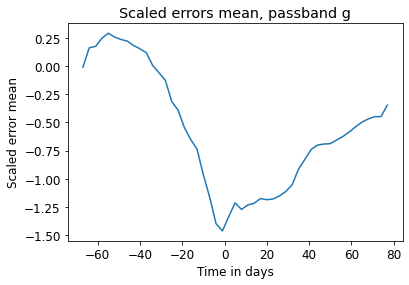

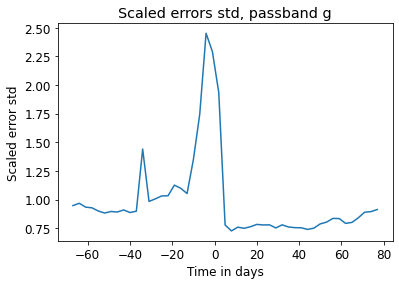

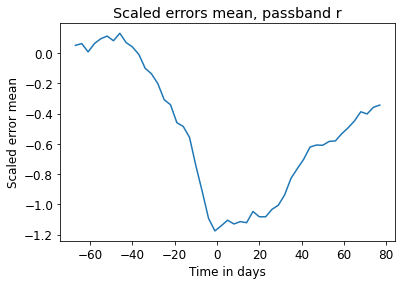

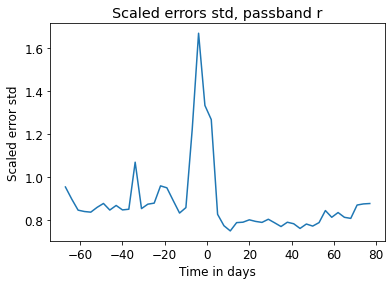

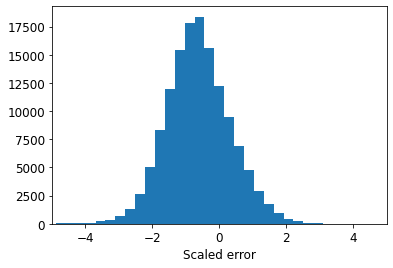

In [12]:
# Analyse predictive uncertainties continued...
import imageio
print("Measured, predicted shapes:", y_test.shape, plot_mean_ypred.shape, plot_sigma_ypred.shape)

maskzeros = (y_test[:,:,2:] == 0)
scaled_error = (plot_mean_ypred - y_test[:,:,:2])/np.sqrt(plot_sigma_ypred**2 + y_test[:,:,2:]**2)
scaled_error[maskzeros] = None
plot_times = np.arange(-67, 80, 3)
mean_scalederrors = {'g': [], 'r': []}
std_scalederrors = {'g': [], 'r': []}
for pbidx, pb in enumerate(passbands):
    images = []
    for tstep, t in enumerate(plot_times):
        tstep_mask = (np.abs(timesX_test[:,1:] - t)) < 1.5  # Mask time steps closest to t. No more than one index per object
        x = scaled_error[:,:,pbidx][tstep_mask]
        xmean = np.nanmean(x)
        xstd = np.nanstd(x)
        # plt.figure()
        # plt.title(f"DNN scaled errors pb: {pb} tstep: {tstep}, mean: {round(xmean,3)}, std: {round(xstd,3)}")
        # plt.hist(x, bins=100)
        # plt.xlim(-5,5)
        # plt.xlabel("Scaled error")
        # filename = f"DNN_scaled_errors_{pb}_{tstep}.png"
        # plt.savefig(filename)
        # plt.show()
        print(f"pb: {pb}, tstep: {tstep}, Mean: {xmean}, std: {xstd}")
        mean_scalederrors[pb].append(xmean)
        std_scalederrors[pb].append(xstd)
        # images.append(imageio.imread(filename))
    # imageio.mimsave(f'DNN_scaled_errors_{pb}.gif', images)
    plt.figure()
    plt.title(f"Scaled errors mean, passband {pb}")
    plt.plot(plot_times, mean_scalederrors[pb])
    plt.xlabel("Time in days")
    plt.ylabel("Scaled error mean")
    plt.savefig(f"DNN Scaled errors mean, passband {pb}.pdf")
    plt.figure()
    plt.title(f"Scaled errors std, passband {pb}")
    plt.plot(plot_times, std_scalederrors[pb])
    plt.xlabel("Time in days")
    plt.ylabel("Scaled error std")
    plt.savefig(f"DNN Scaled errors std, passband {pb}.pdf")


print("Scaled_error shape:", scaled_error.shape, scaled_error.flatten().shape)
plt.figure()
plt.hist(scaled_error.flatten(), bins=200);
plt.xlim(-5,5)
plt.xlabel("Scaled error")
plt.savefig(f"DNN Scaled errors all.pdf")
print(f"Mean: {np.mean(scaled_error.flatten())}, std: {np.std(scaled_error.flatten())}")

In [13]:
# sandbox
print(timesX_train[:,1:])
# nearest_idx = 
tstep_mask = (np.abs(timesX_test[:,1:] - 0)) < 1.5
scaled_error[:,:,1].shape, timesX_test[:,1:].shape
scaled_error[:,:,1][tstep_mask]

# helpers.find_nearest(timesX_train[:,1:], plot_times[0])

[[-56.957901   -53.957901   -50.957901   ...  81.042099    84.042099
   87.042099  ]
 [-63.95819855 -60.95819855 -57.95819855 ...  74.04180145  77.04180145
   80.04180145]
 [-65.12719727 -62.12719727 -59.12719727 ...   0.           0.
    0.        ]
 ...
 [ -7.94480038  -4.94480038  -1.94480038 ... 130.05519962 133.05519962
  136.05519962]
 [-65.6835022  -62.6835022  -59.6835022  ...   0.           0.
    0.        ]
 [-94.79219818 -91.79219818 -88.79219818 ...   0.           0.
    0.        ]]


array([-1.62878678,         nan,         nan, ...,         nan,
               nan,         nan])

Measured, predicted shapes: (2319, 49, 4) (2319, 49, 2) (2319, 49, 2)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


class: SNIa-norm, pb: g, tstep: 0, Mean: 0.1156308253854594, std: 0.9992660779184263
class: SNIa-norm, pb: g, tstep: 1, Mean: 0.16492987999572392, std: 0.9424371026326654
class: SNIa-norm, pb: g, tstep: 2, Mean: 0.1540482453418697, std: 0.9065236144346662
class: SNIa-norm, pb: g, tstep: 3, Mean: 0.21922686221855908, std: 0.8807704151836748
class: SNIa-norm, pb: g, tstep: 4, Mean: 0.18551813461730027, std: 0.8946924404382264
class: SNIa-norm, pb: g, tstep: 5, Mean: 0.16926905463337516, std: 0.8606015805728754
class: SNIa-norm, pb: g, tstep: 6, Mean: 0.15942735531093358, std: 0.882316616687306
class: SNIa-norm, pb: g, tstep: 7, Mean: 0.131889782417191, std: 0.8681968930545013
class: SNIa-norm, pb: g, tstep: 8, Mean: 0.18589396256323495, std: 0.8735920338531517
class: SNIa-norm, pb: g, tstep: 9, Mean: 0.16969611309873042, std: 0.8782094439417153
class: SNIa-norm, pb: g, tstep: 10, Mean: 0.18410524575534268, std: 0.8834360919903392
class: SNIa-norm, pb: g, tstep: 11, Mean: 0.18356279863328

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class: SNIa-norm, pb: g, tstep: 19, Mean: -0.5911196661233905, std: 1.0862321906920653
class: SNIa-norm, pb: g, tstep: 20, Mean: -0.890095535843495, std: 3.833939600781154
class: SNIa-norm, pb: g, tstep: 21, Mean: -0.6433406885345592, std: 1.1199015865002304
class: SNIa-norm, pb: g, tstep: 22, Mean: -0.7002926249089167, std: 6.211671901144943
class: SNIa-norm, pb: g, tstep: 23, Mean: -0.2579561898218483, std: 1.4161871955897791
class: SNIa-norm, pb: g, tstep: 24, Mean: -0.11174010900779406, std: 0.45462758956215843
class: SNIa-norm, pb: g, tstep: 25, Mean: -0.1339352440239361, std: 0.44209114716196485
class: SNIa-norm, pb: g, tstep: 26, Mean: -0.13794441839779195, std: 0.4719977904656675
class: SNIa-norm, pb: g, tstep: 27, Mean: -0.1472080988119095, std: 0.49258985812762285
class: SNIa-norm, pb: g, tstep: 28, Mean: -0.1425217148468908, std: 0.5429574053839972
class: SNIa-norm, pb: g, tstep: 29, Mean: -0.1322309320499958, std: 0.5376142266006949
class: SNIa-norm, pb: g, tstep: 30, Mean:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class: SNIa-norm, pb: r, tstep: 0, Mean: 0.03498081922056583, std: 0.9982338524710951
class: SNIa-norm, pb: r, tstep: 1, Mean: 0.2166454445081744, std: 0.9144009759515328
class: SNIa-norm, pb: r, tstep: 2, Mean: 0.25292442599689713, std: 0.8593189017201233
class: SNIa-norm, pb: r, tstep: 3, Mean: 0.30411643511847325, std: 0.8470258377966708
class: SNIa-norm, pb: r, tstep: 4, Mean: 0.25886288463734847, std: 0.8602544121186758
class: SNIa-norm, pb: r, tstep: 5, Mean: 0.23081746505617307, std: 0.8781481826346432
class: SNIa-norm, pb: r, tstep: 6, Mean: 0.24964049499262664, std: 0.850044169507897
class: SNIa-norm, pb: r, tstep: 7, Mean: 0.23061727286670036, std: 0.8483322026971708
class: SNIa-norm, pb: r, tstep: 8, Mean: 0.2701242028217057, std: 0.8457227311485532
class: SNIa-norm, pb: r, tstep: 9, Mean: 0.2868754465100878, std: 0.8343914915460706
class: SNIa-norm, pb: r, tstep: 10, Mean: 0.26021468640981504, std: 0.8306506399753721
class: SNIa-norm, pb: r, tstep: 11, Mean: 0.2757606809316

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan
Measured, predicted shapes: (2319, 49, 4) (2319, 49, 2) (2319, 49, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class: SNIa-norm, pb: g, tstep: 0, Mean: 0.1459910149299207, std: 1.0161178213793418
class: SNIa-norm, pb: g, tstep: 1, Mean: 0.13588801372144851, std: 1.0034174204697845
class: SNIa-norm, pb: g, tstep: 2, Mean: 0.12821151820005927, std: 0.96893294171033
class: SNIa-norm, pb: g, tstep: 3, Mean: 0.22070544719659205, std: 0.9343782611326126
class: SNIa-norm, pb: g, tstep: 4, Mean: 0.21817560082341858, std: 0.9463770395397215
class: SNIa-norm, pb: g, tstep: 5, Mean: 0.21206758788604904, std: 0.8910063493600057
class: SNIa-norm, pb: g, tstep: 6, Mean: 0.20746635841239666, std: 0.9091791333123697
class: SNIa-norm, pb: g, tstep: 7, Mean: 0.1731422722068391, std: 0.9090248885582195
class: SNIa-norm, pb: g, tstep: 8, Mean: 0.2187872927775319, std: 0.9191223683557763
class: SNIa-norm, pb: g, tstep: 9, Mean: 0.20843386239570816, std: 0.9267088165084325
class: SNIa-norm, pb: g, tstep: 10, Mean: 0.21401648543534874, std: 0.9366823745331561
class: SNIa-norm, pb: g, tstep: 11, Mean: 0.21615231499728

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


class: SNIa-norm, pb: r, tstep: 0, Mean: 0.03755692702064831, std: 1.0005823087480306
class: SNIa-norm, pb: r, tstep: 1, Mean: 0.1551869711229335, std: 0.903644764161953
class: SNIa-norm, pb: r, tstep: 2, Mean: 0.1958848306953943, std: 0.8878703172558693
class: SNIa-norm, pb: r, tstep: 3, Mean: 0.27801207137108724, std: 0.8493812897704229
class: SNIa-norm, pb: r, tstep: 4, Mean: 0.23113615026350465, std: 0.8438069858840688
class: SNIa-norm, pb: r, tstep: 5, Mean: 0.2041134640126955, std: 0.8631202963472565
class: SNIa-norm, pb: r, tstep: 6, Mean: 0.22576667296222816, std: 0.8385157057018007
class: SNIa-norm, pb: r, tstep: 7, Mean: 0.2123934780306758, std: 0.824326269031193
class: SNIa-norm, pb: r, tstep: 8, Mean: 0.23734183362296957, std: 0.8168368630134178
class: SNIa-norm, pb: r, tstep: 9, Mean: 0.2574918027345591, std: 0.7996419808409918
class: SNIa-norm, pb: r, tstep: 10, Mean: 0.24220806694610045, std: 0.8016149259445698
class: SNIa-norm, pb: r, tstep: 11, Mean: 0.2429492808406799

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Mean: nan, std: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


ResourceExhaustedError: ignored

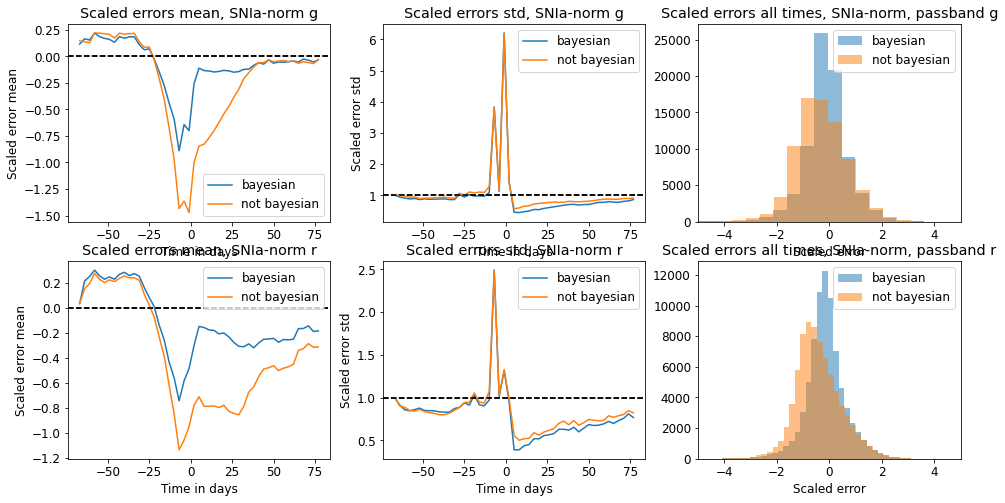

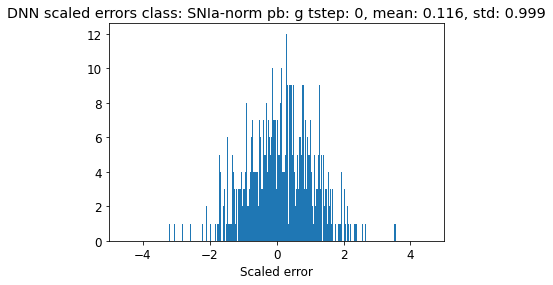

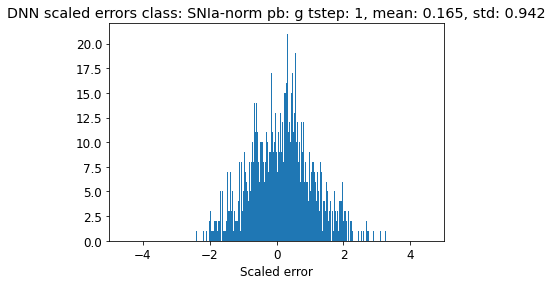

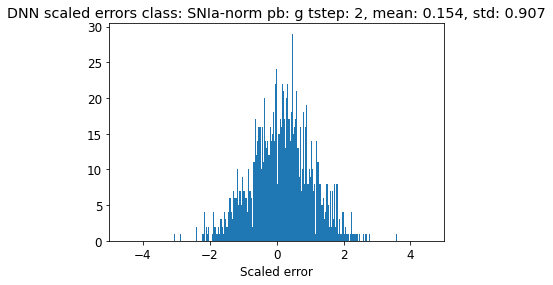

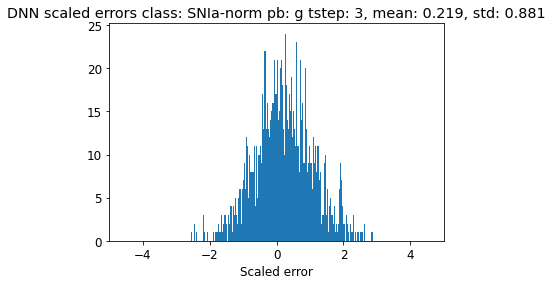

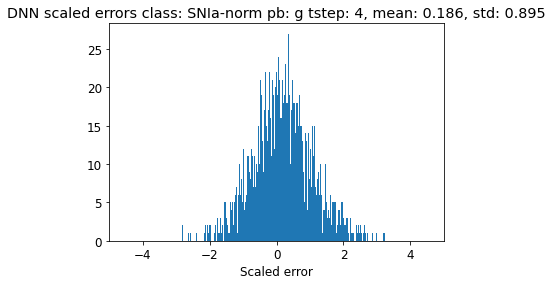

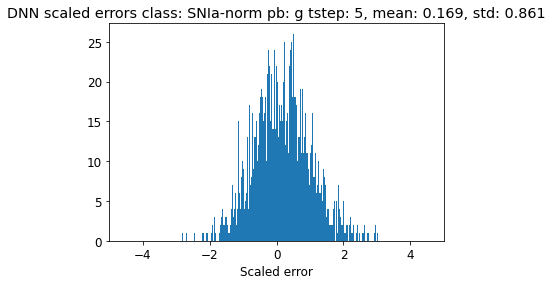

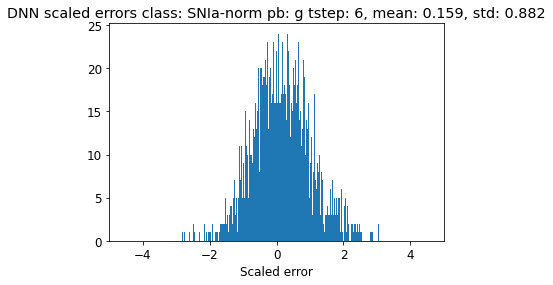

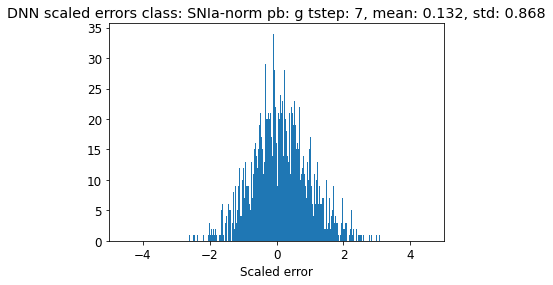

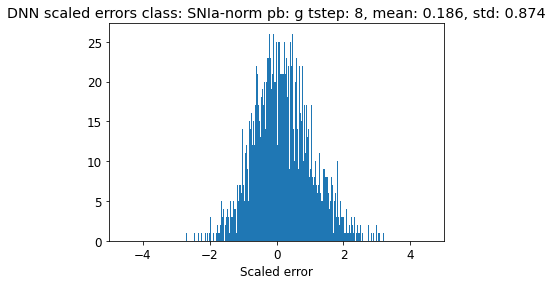

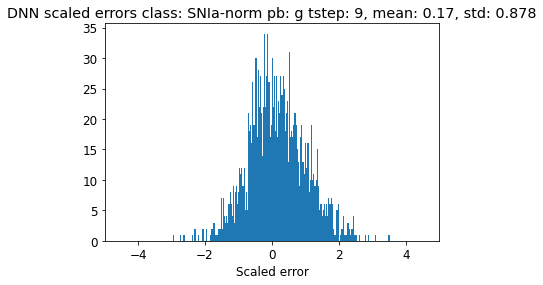

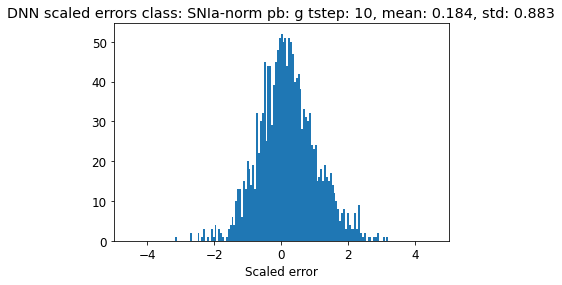

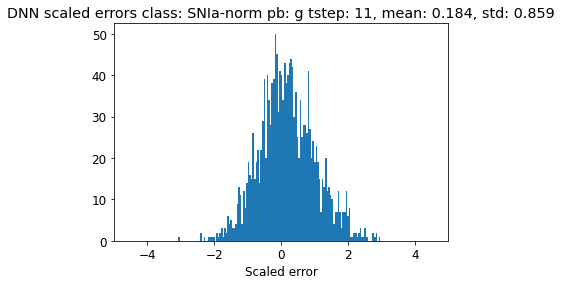

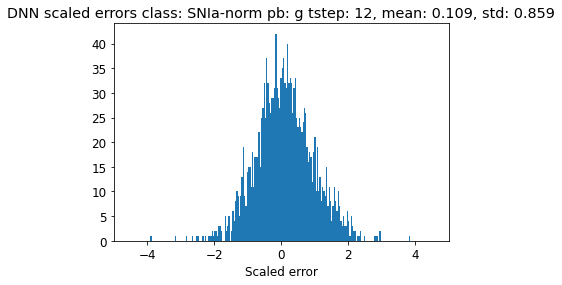

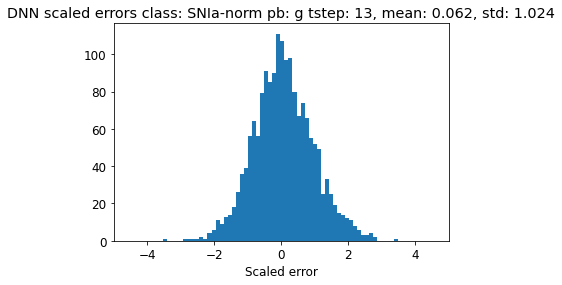

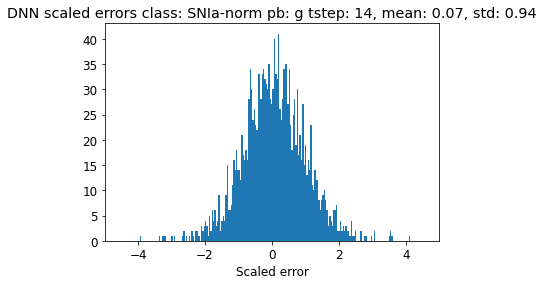

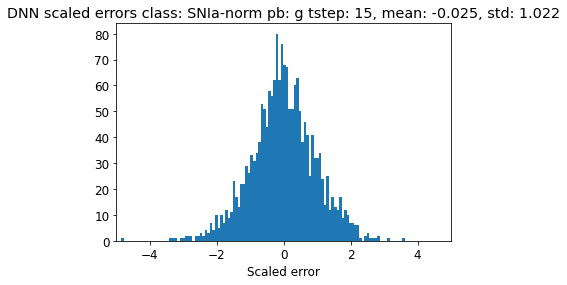

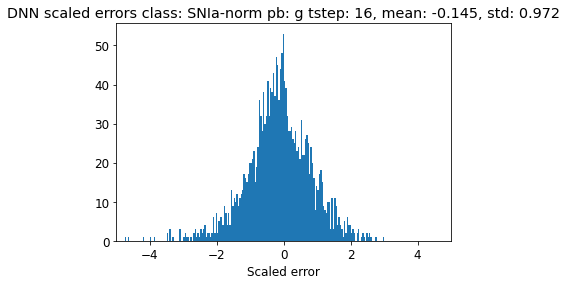

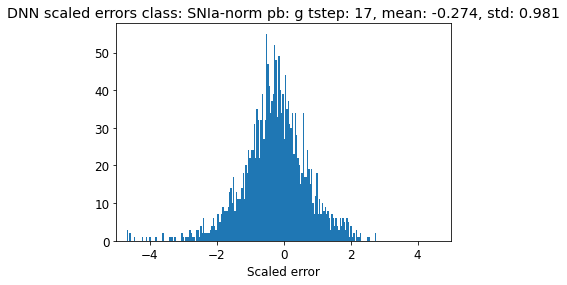

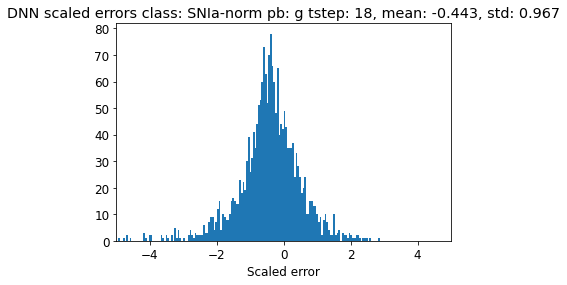

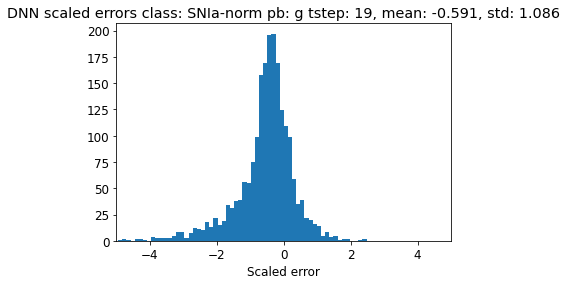

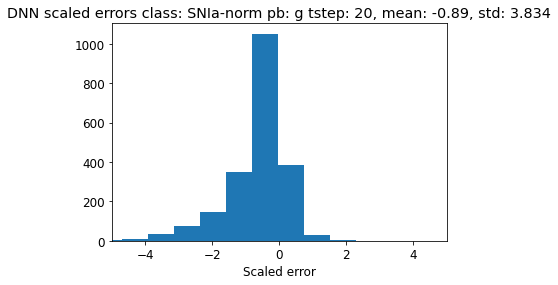

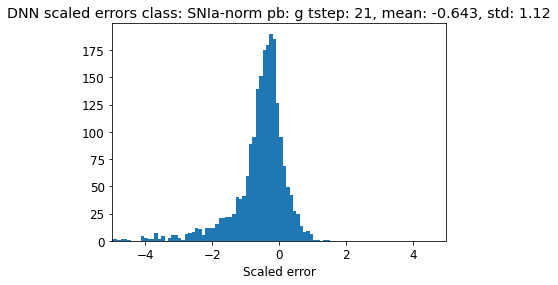

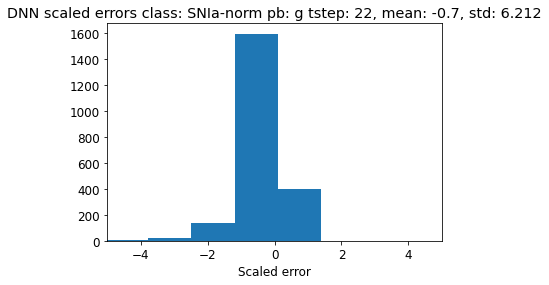

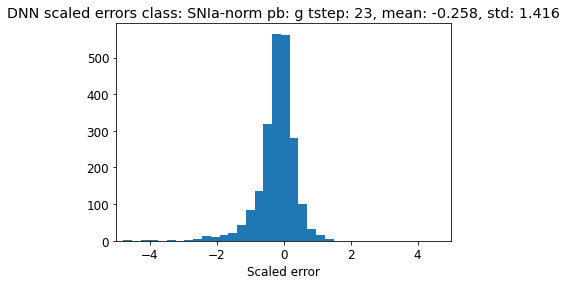

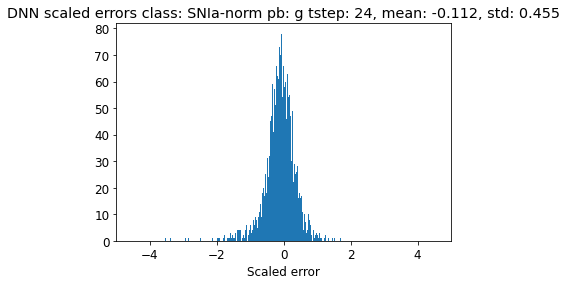

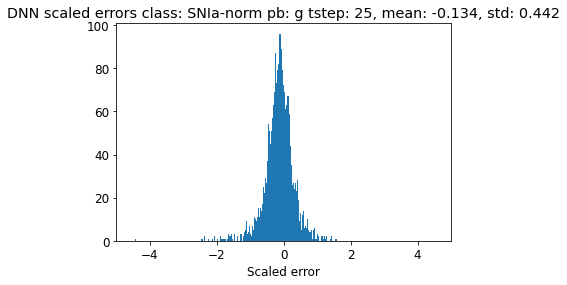

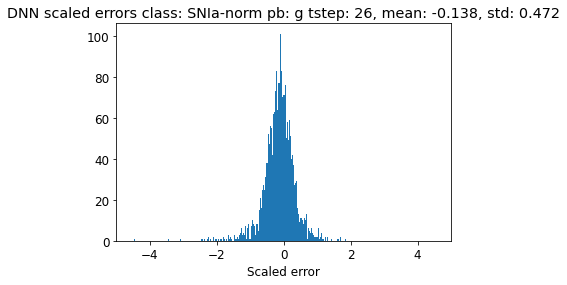

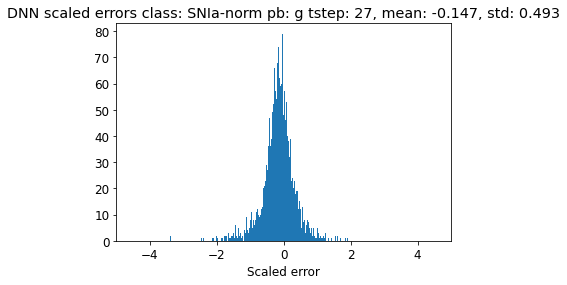

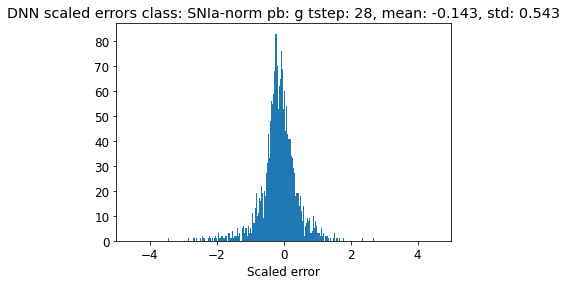

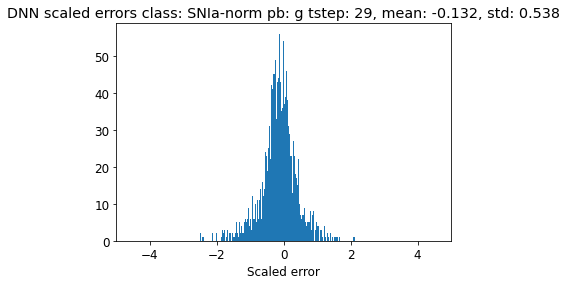

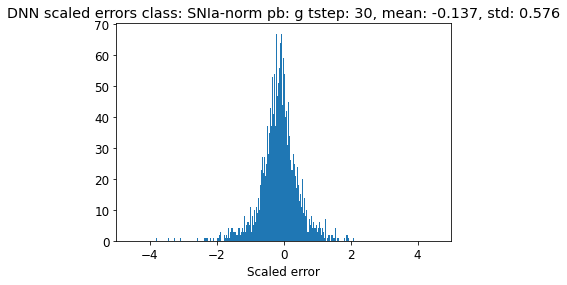

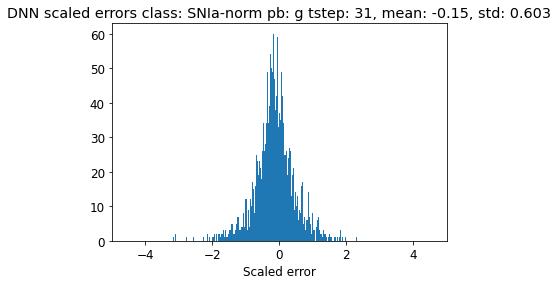

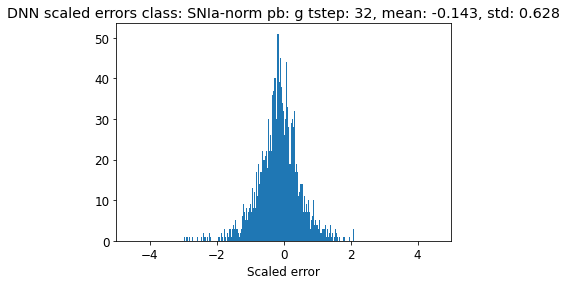

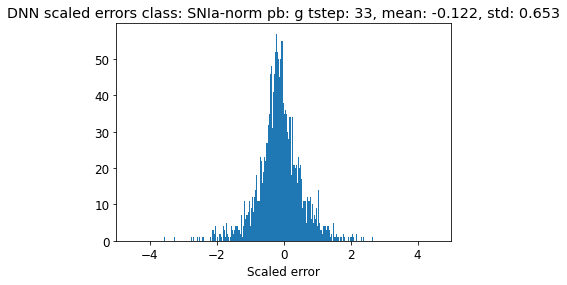

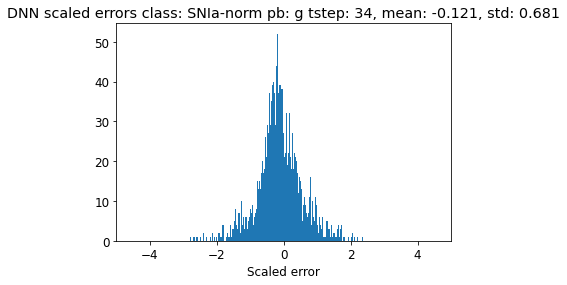

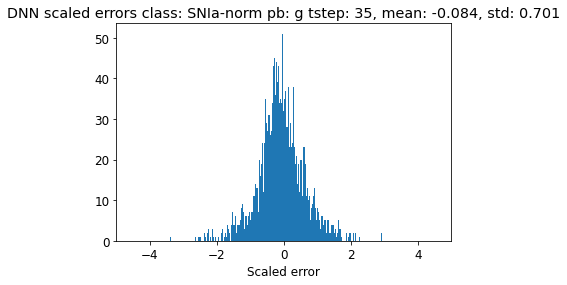

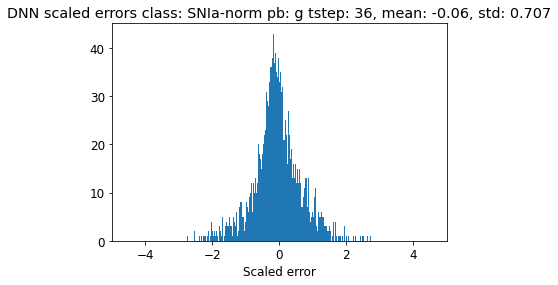

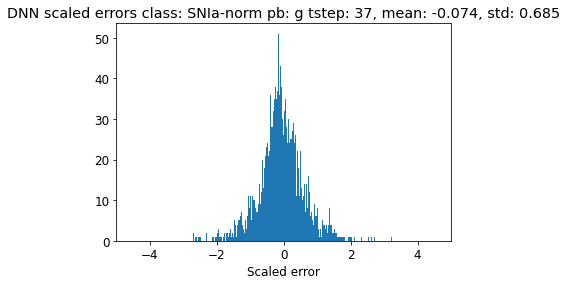

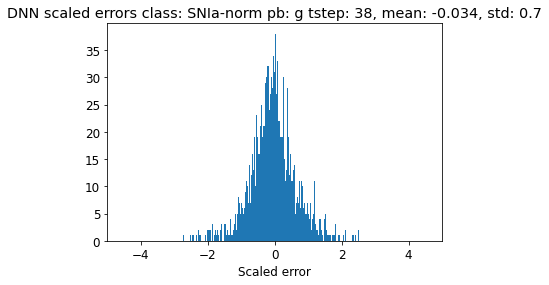

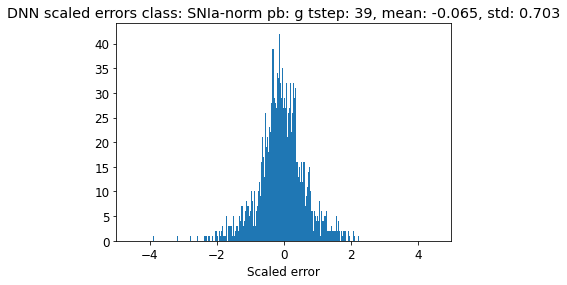

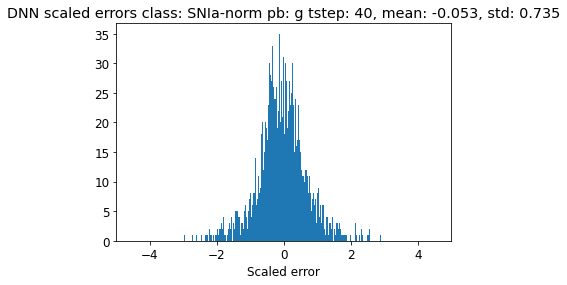

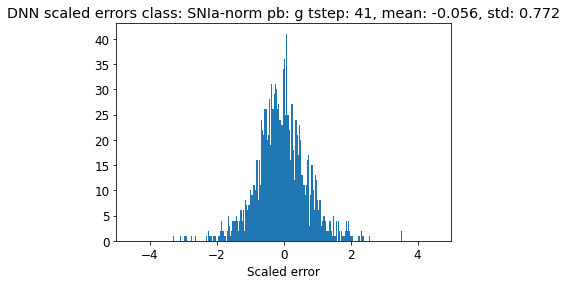

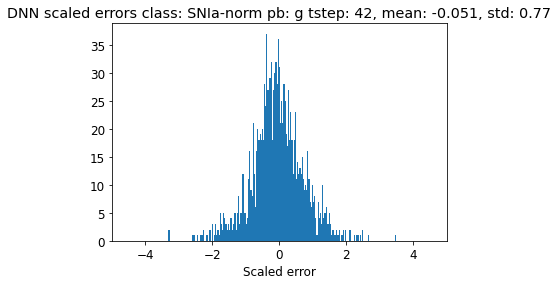

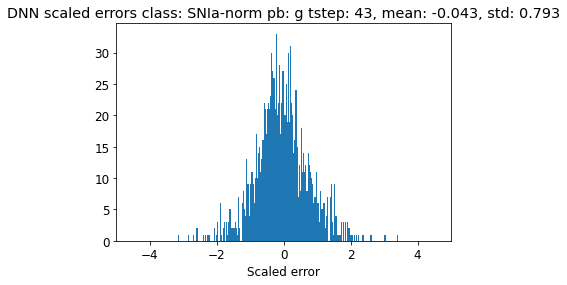

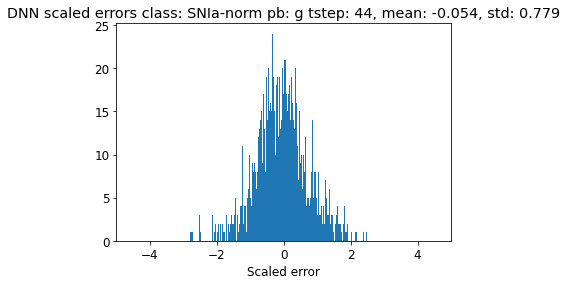

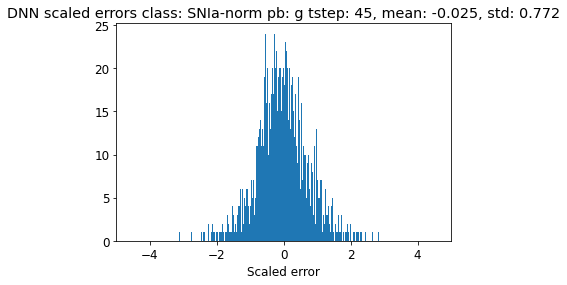

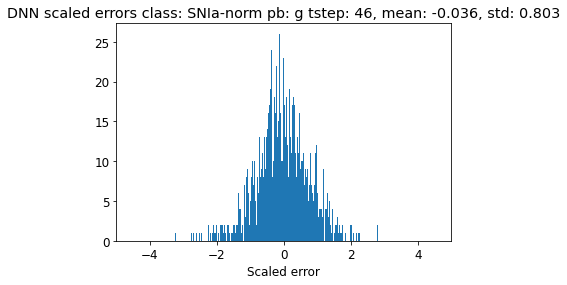

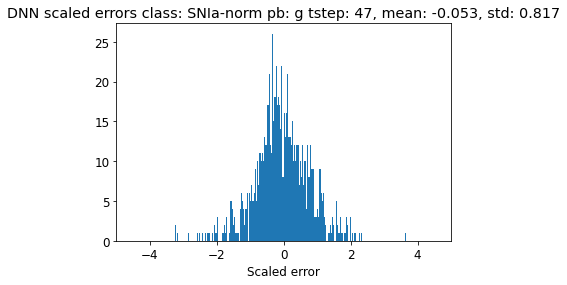

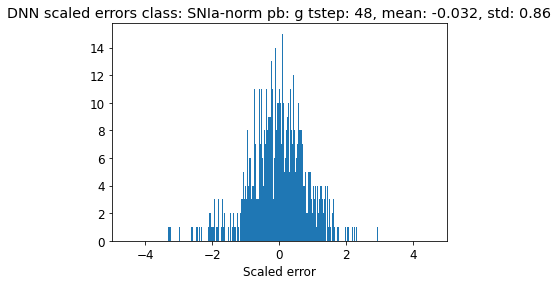

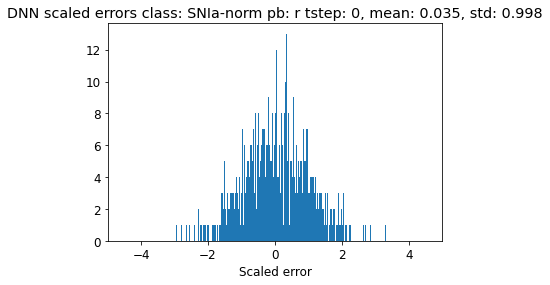

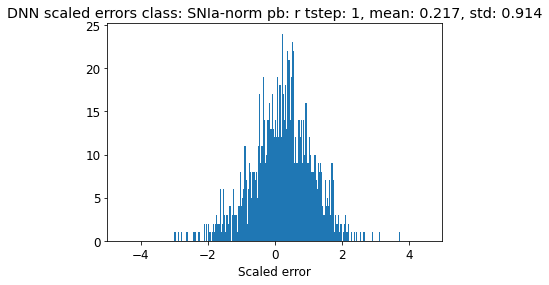

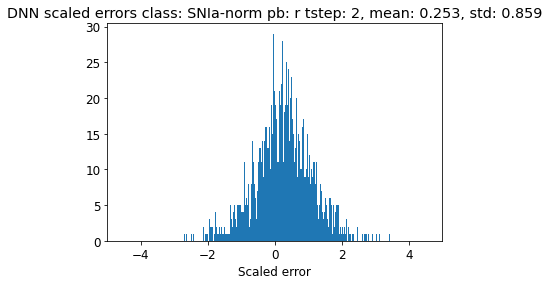

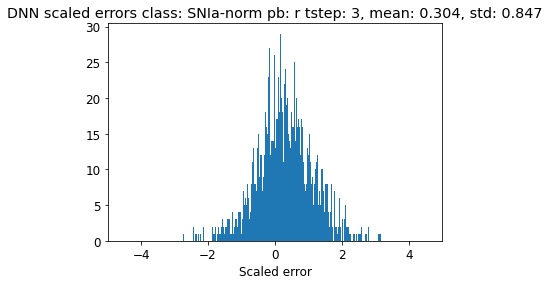

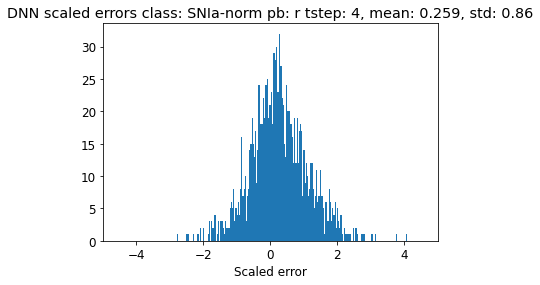

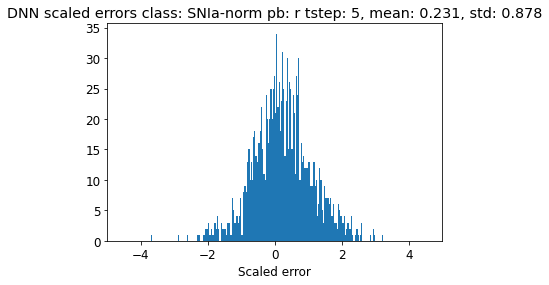

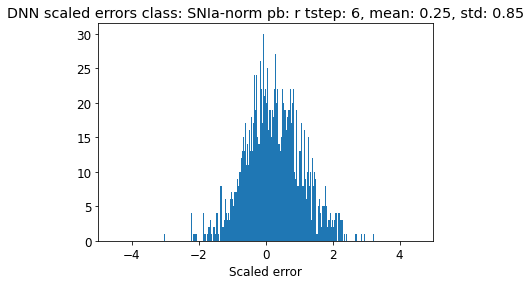

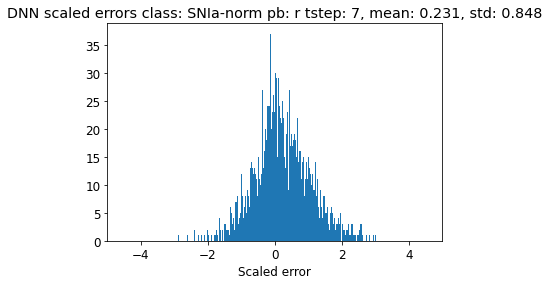

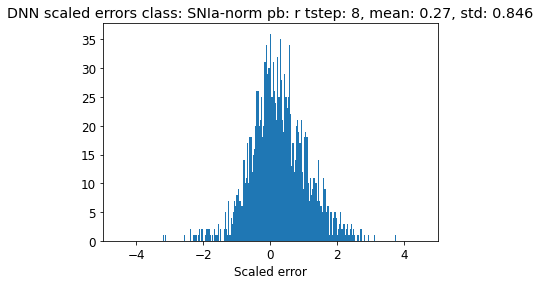

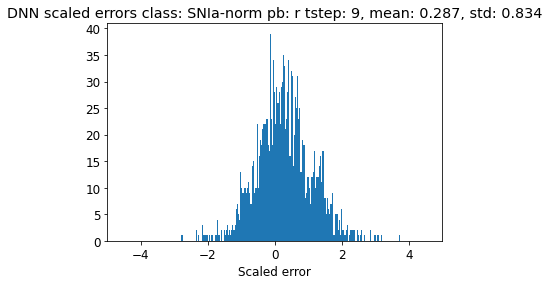

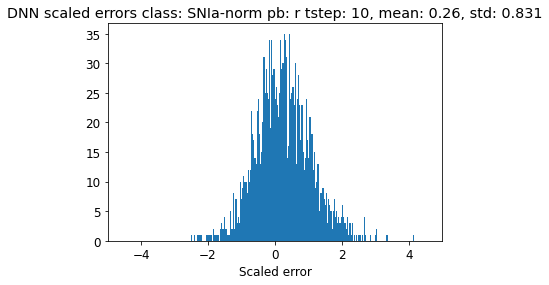

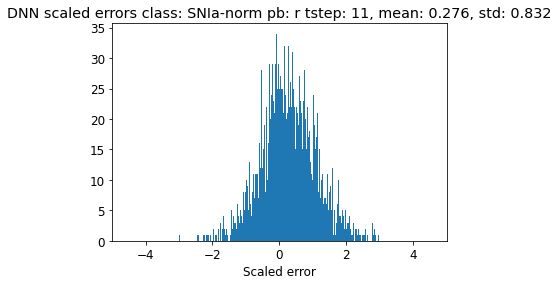

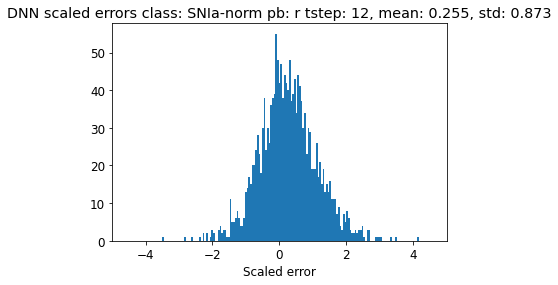

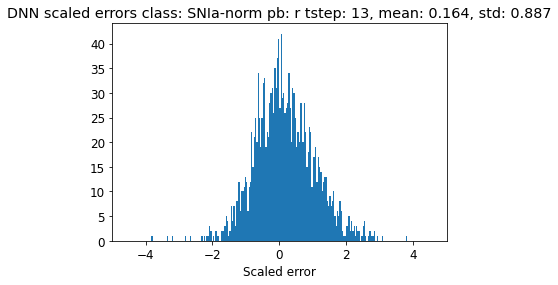

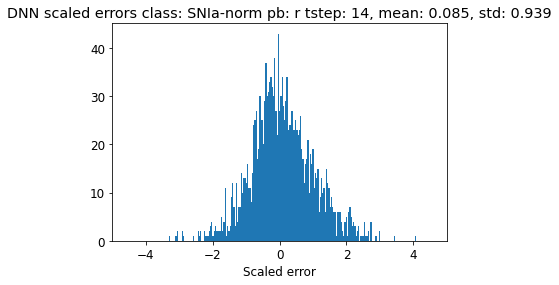

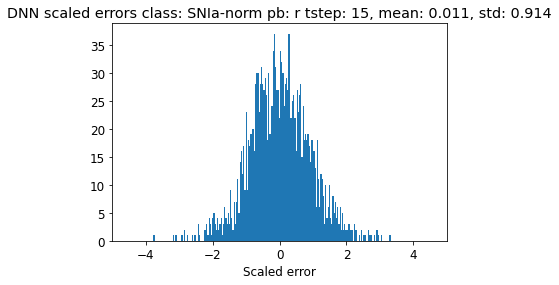

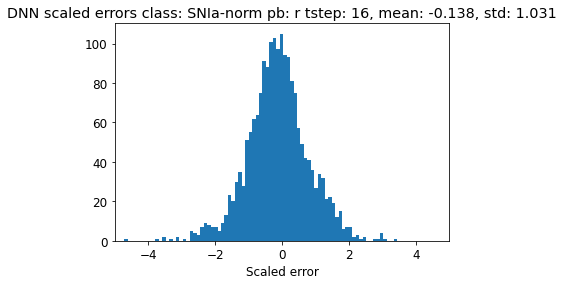

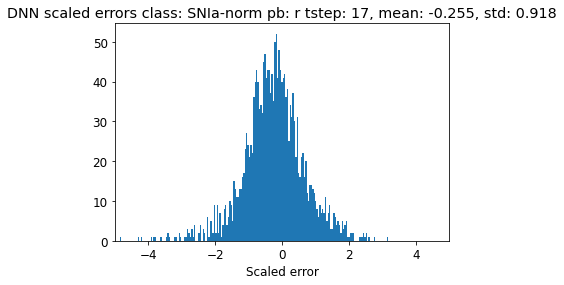

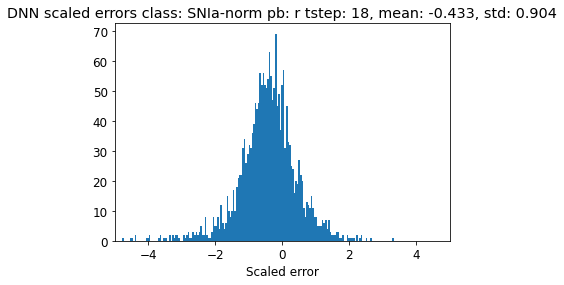

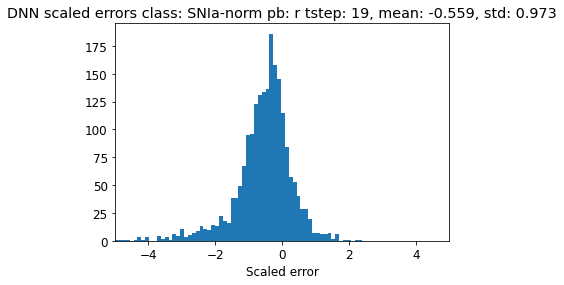

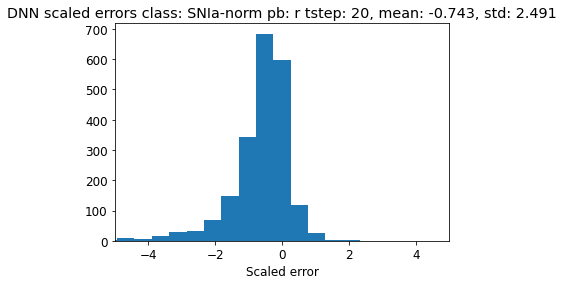

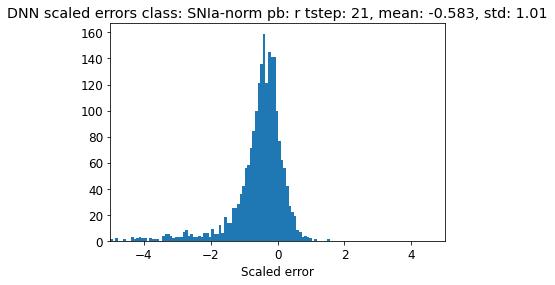

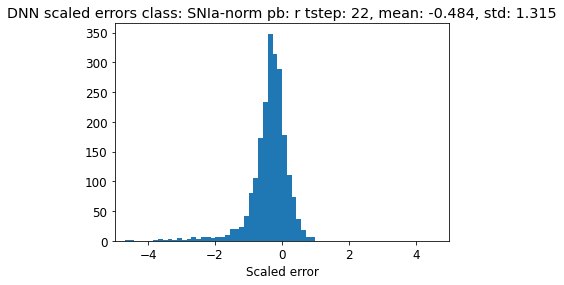

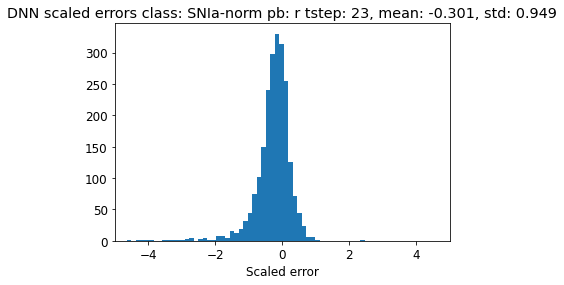

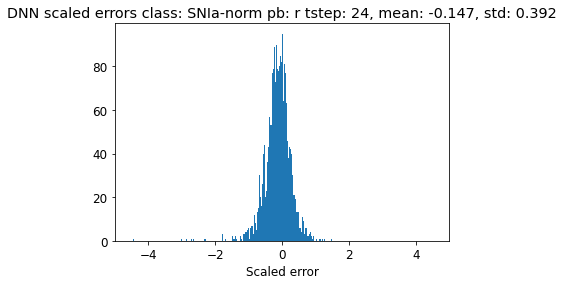

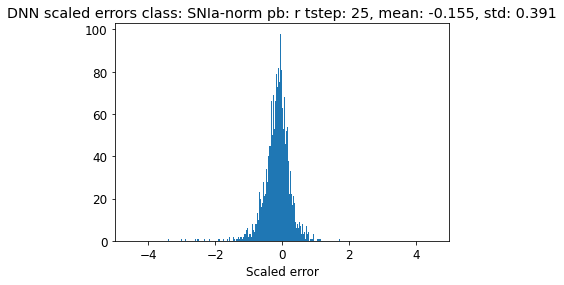

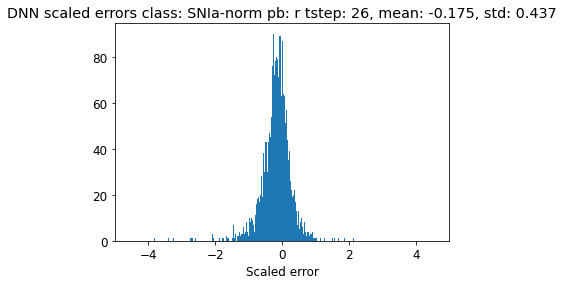

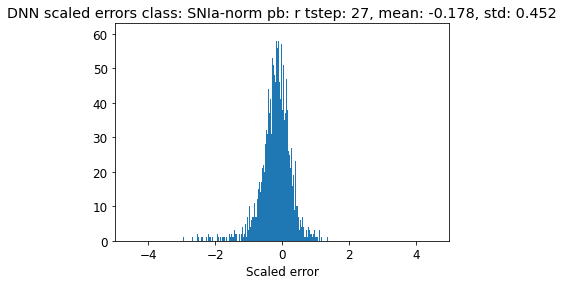

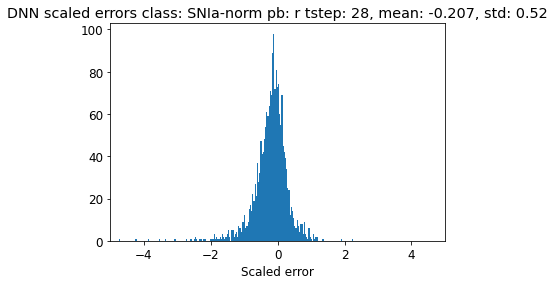

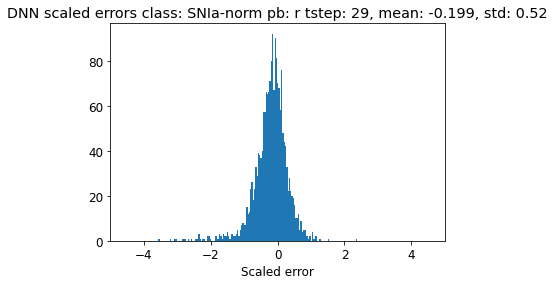

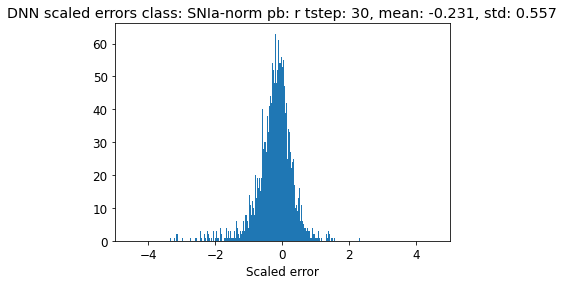

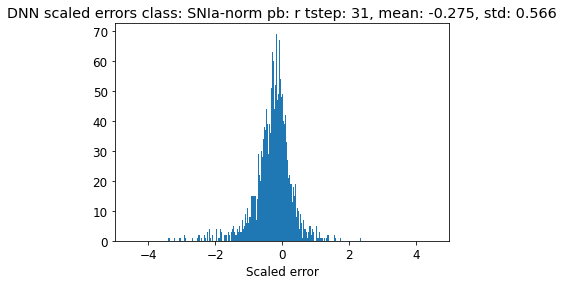

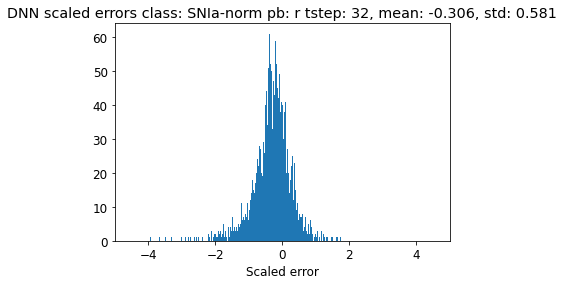

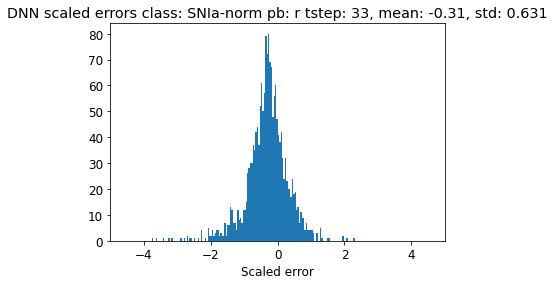

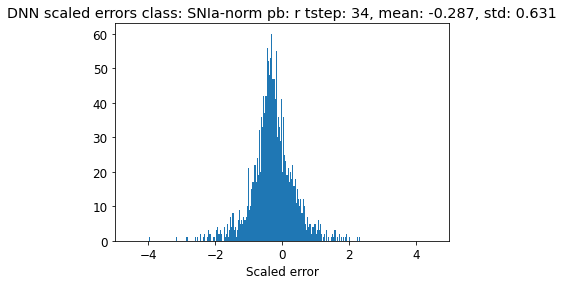

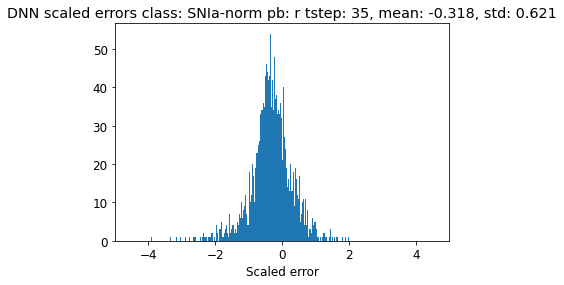

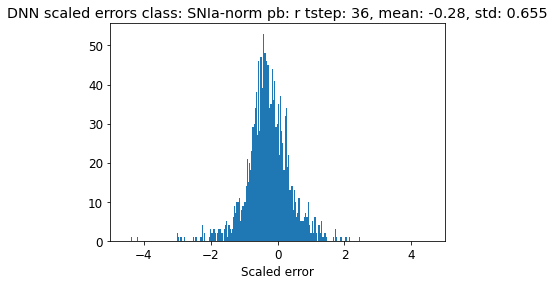

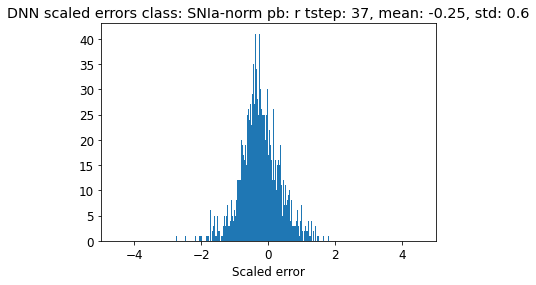

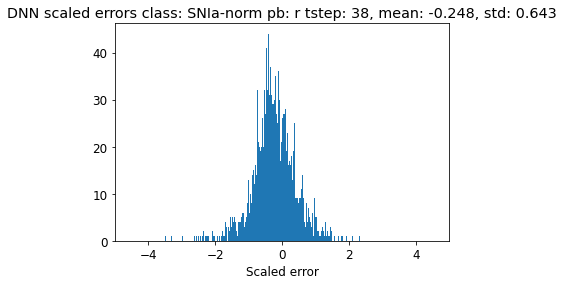

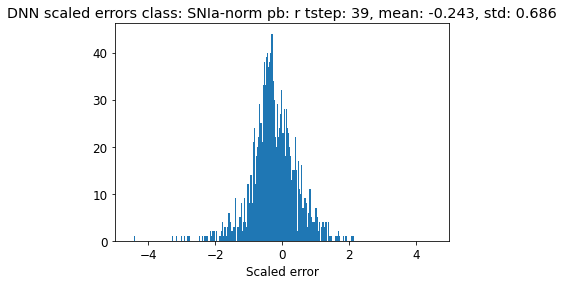

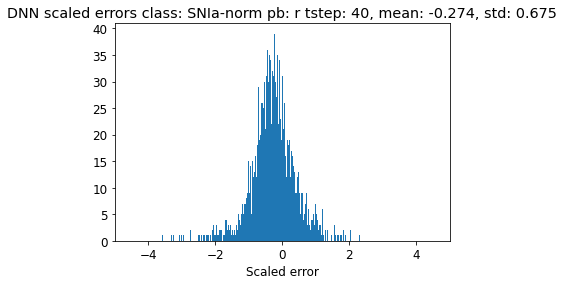

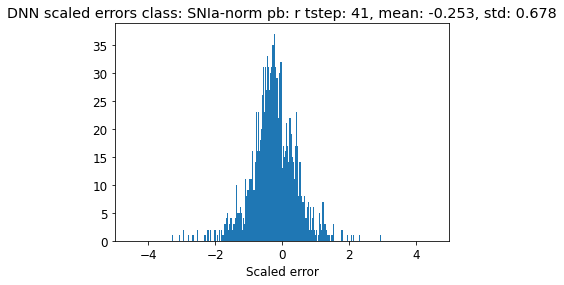

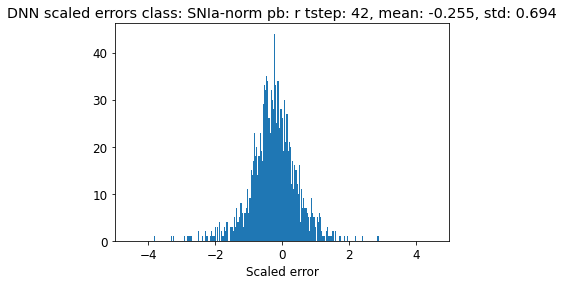

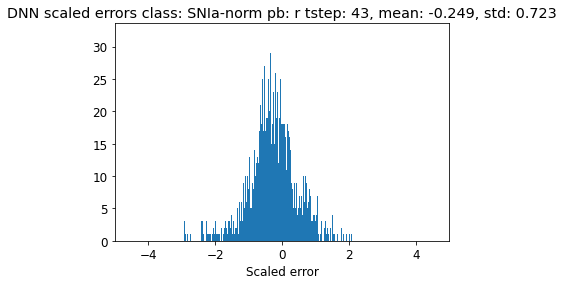

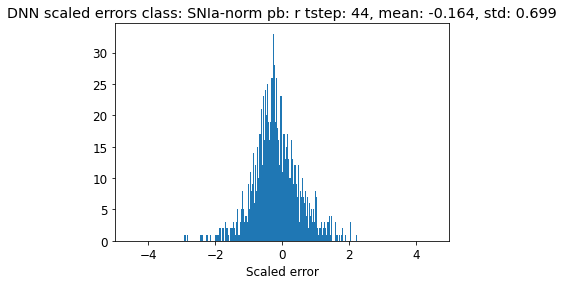

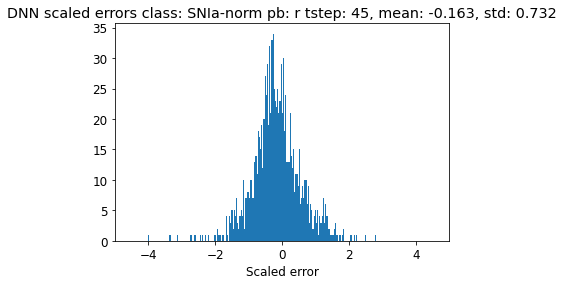

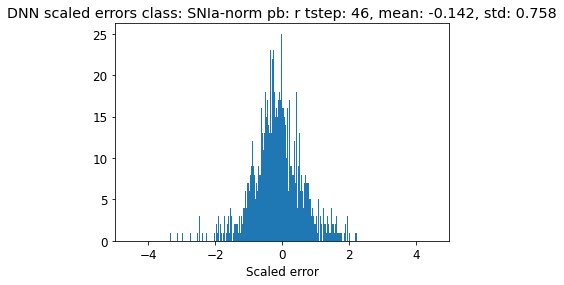

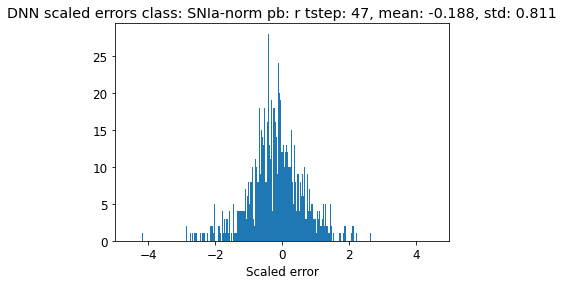

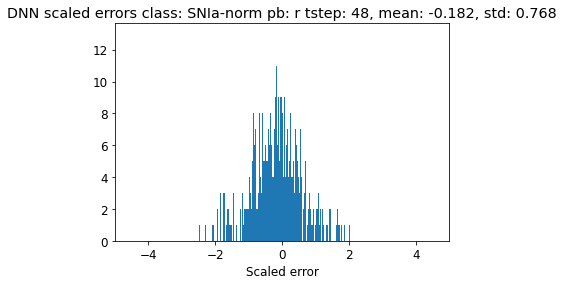

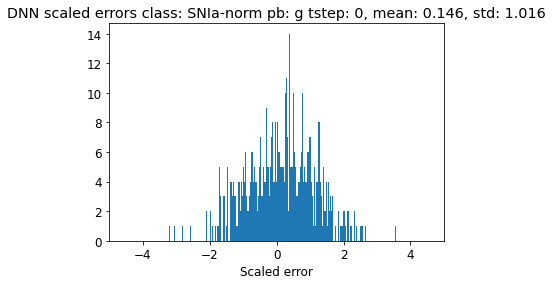

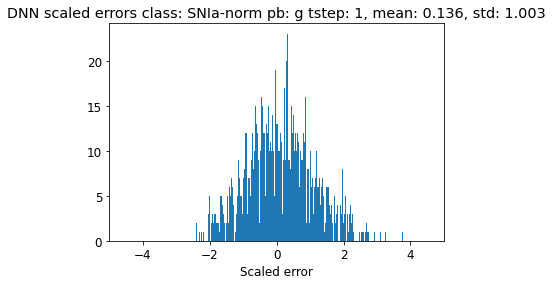

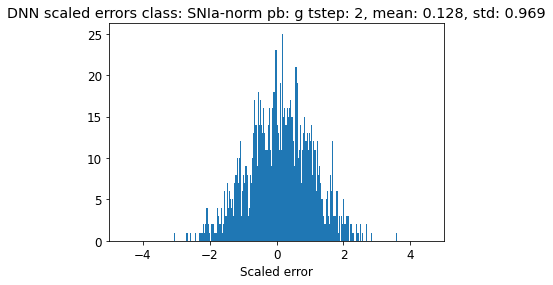

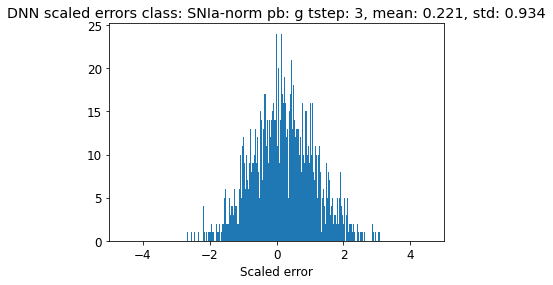

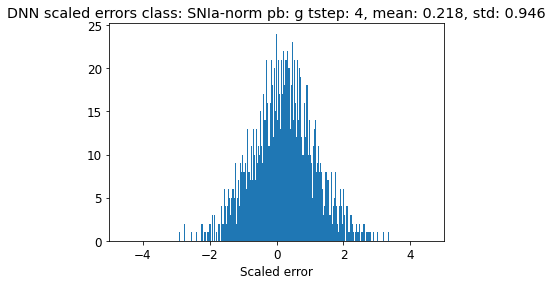

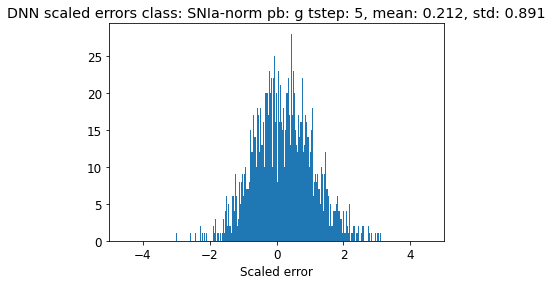

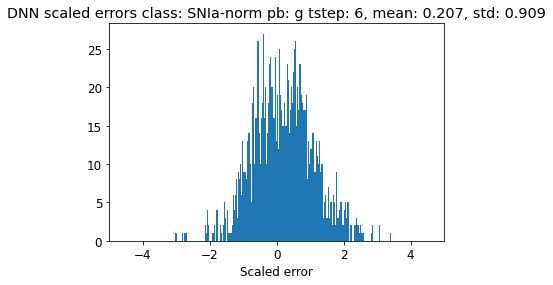

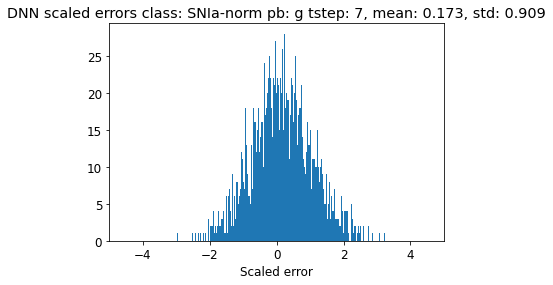

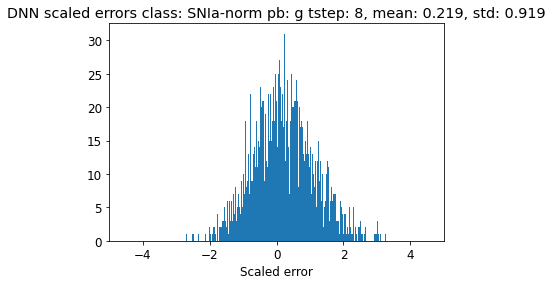

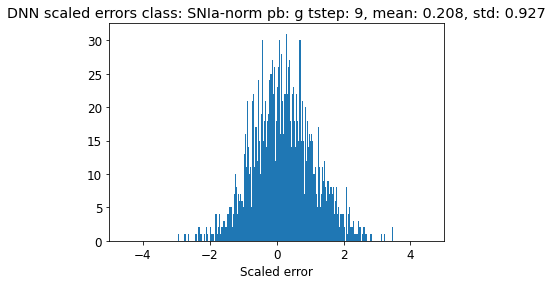

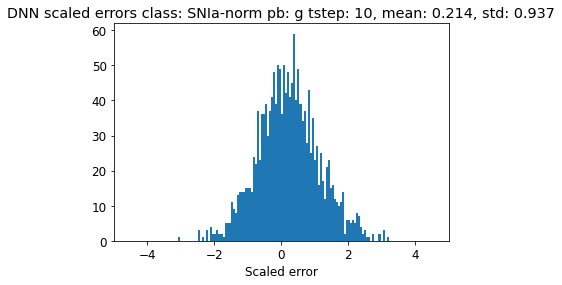

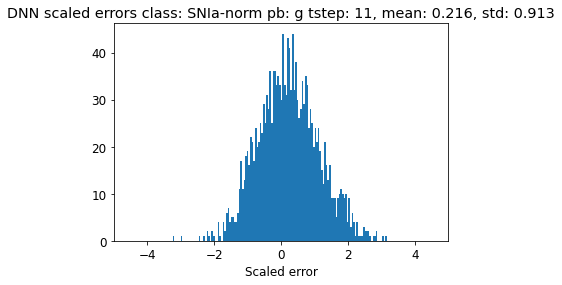

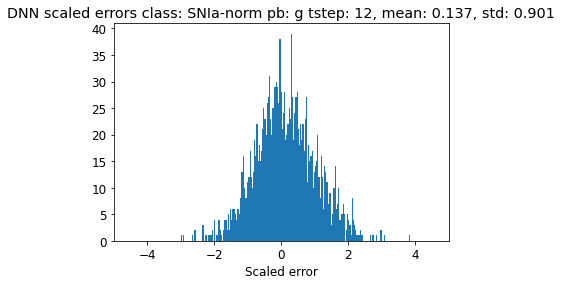

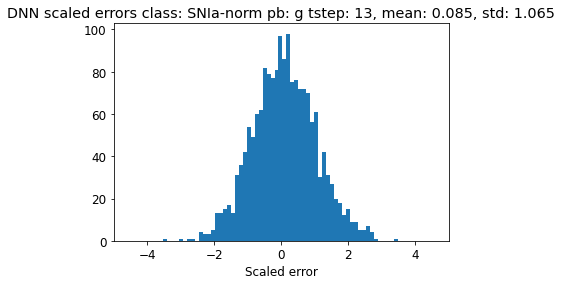

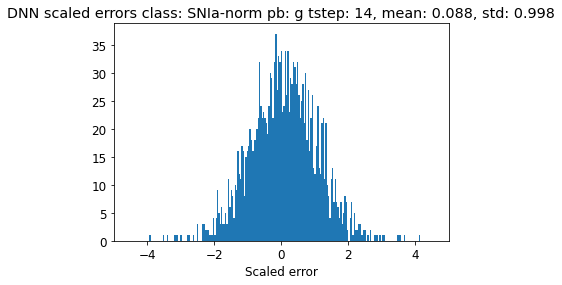

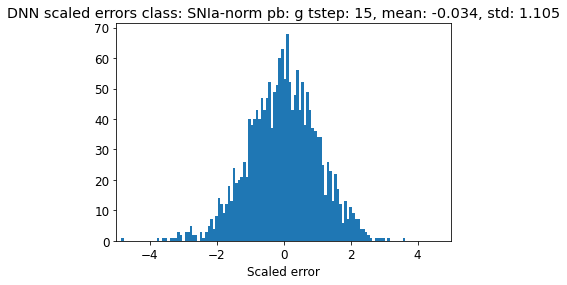

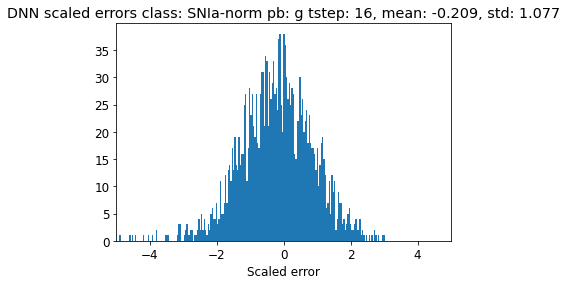

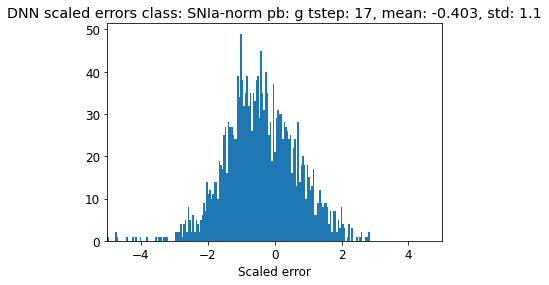

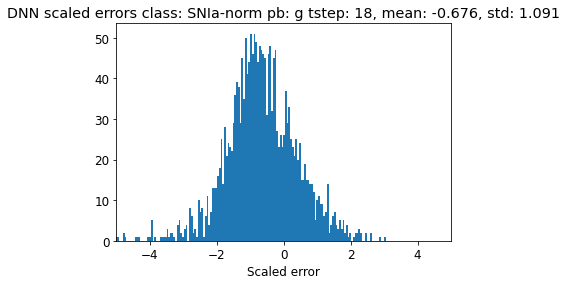

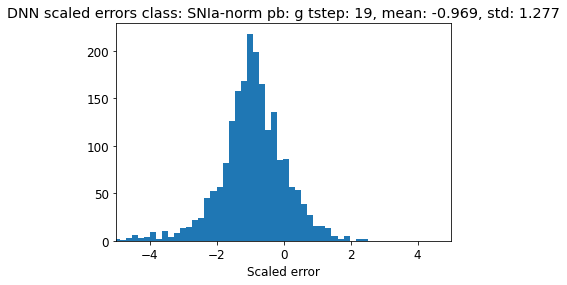

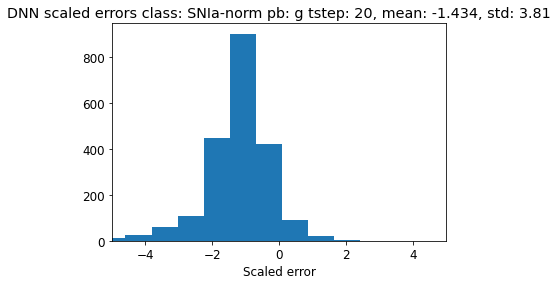

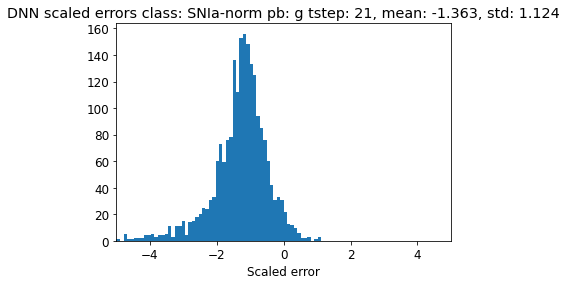

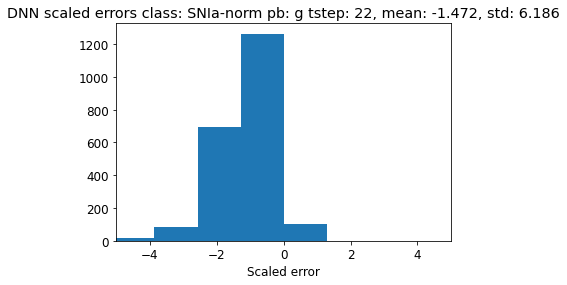

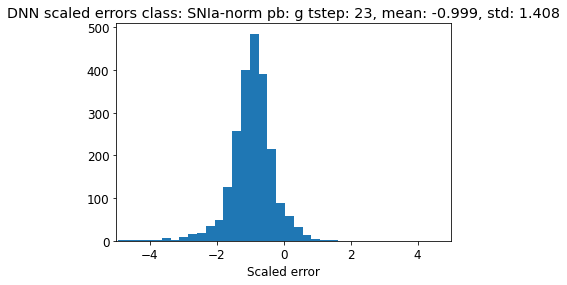

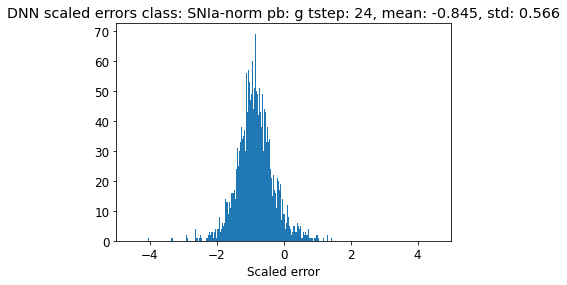

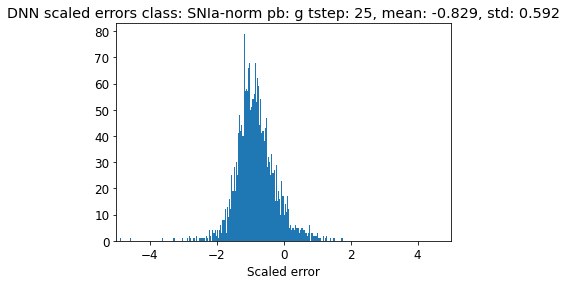

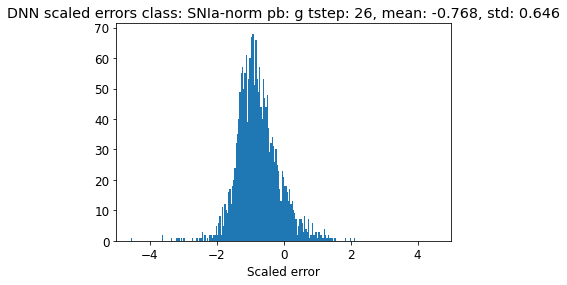

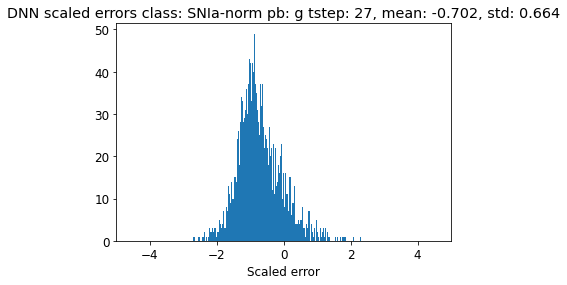

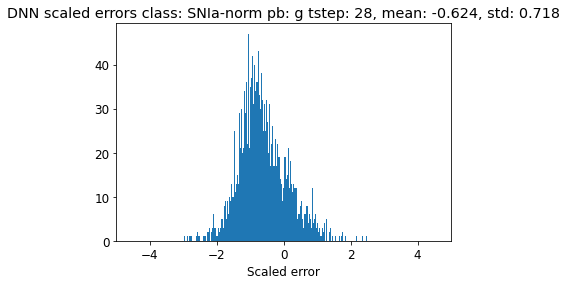

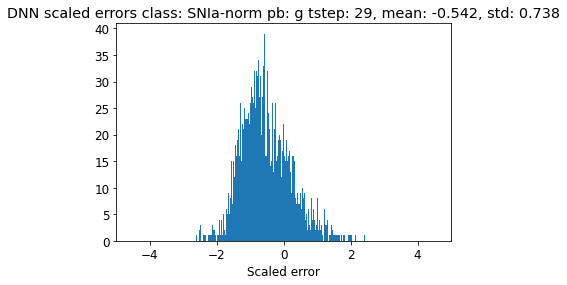

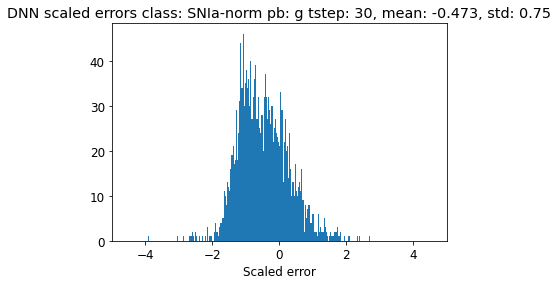

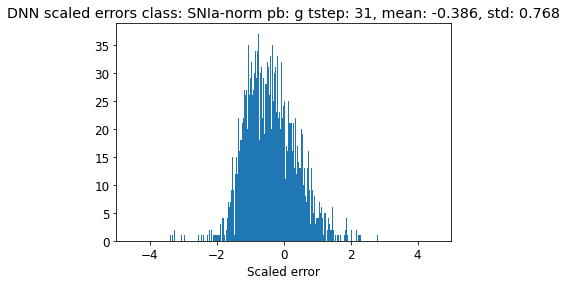

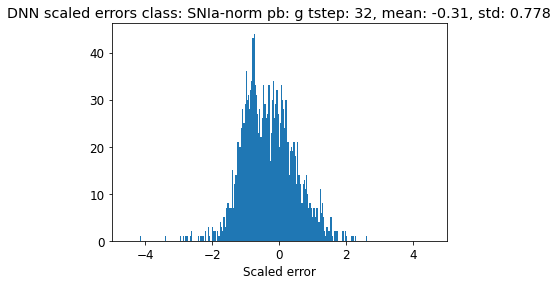

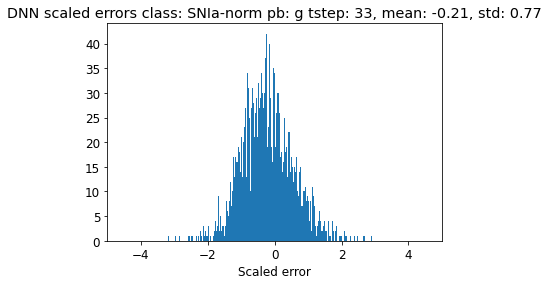

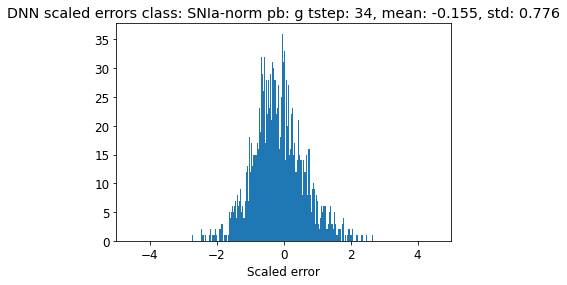

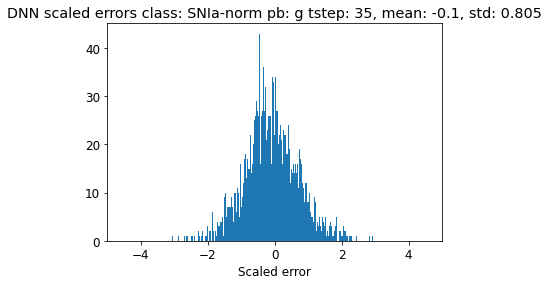

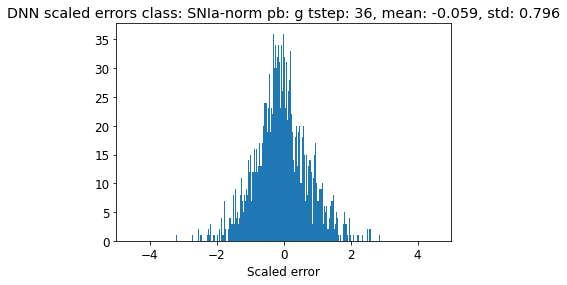

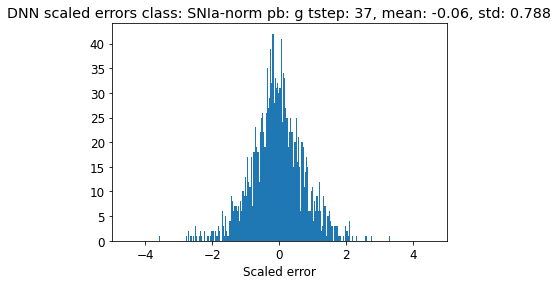

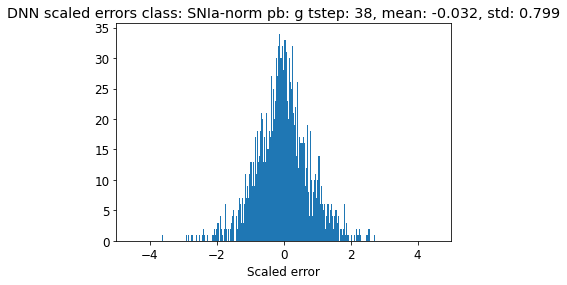

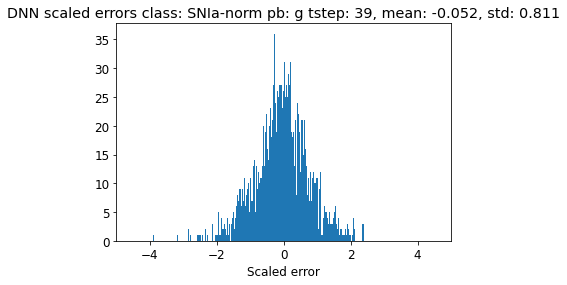

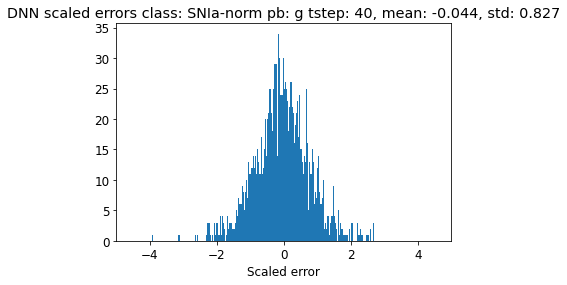

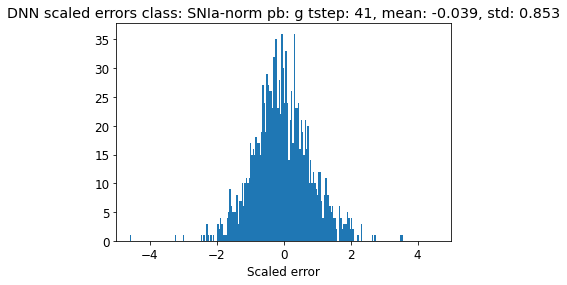

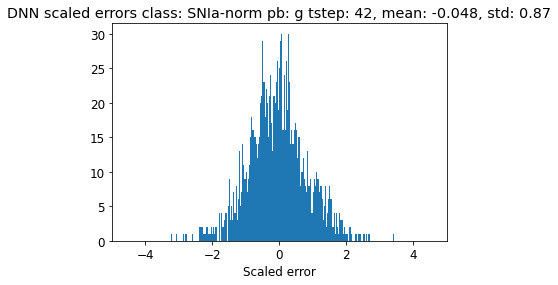

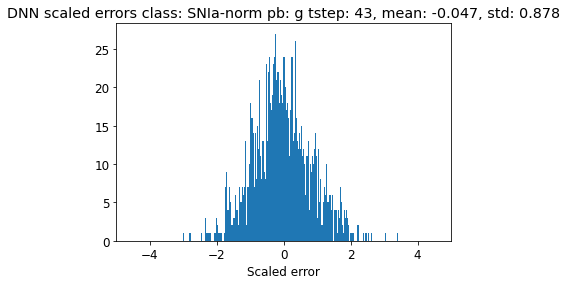

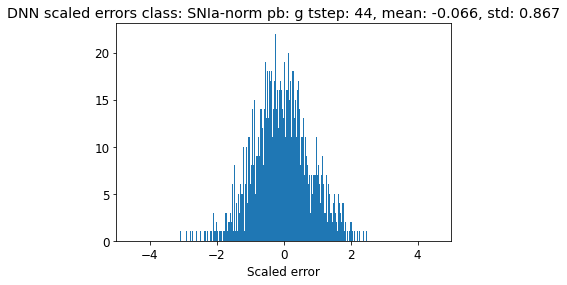

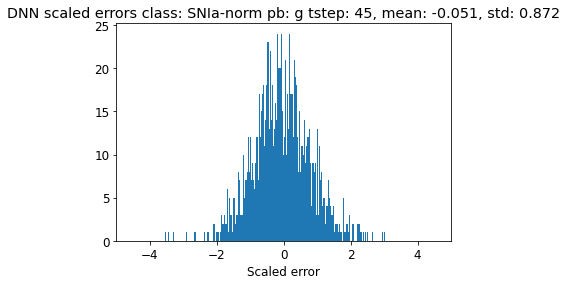

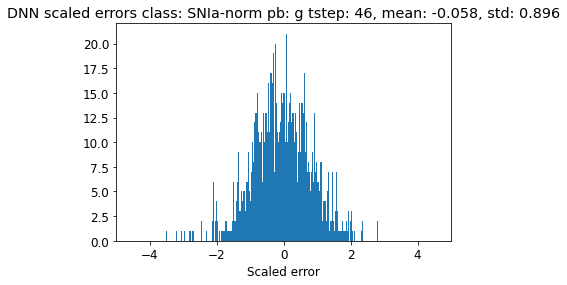

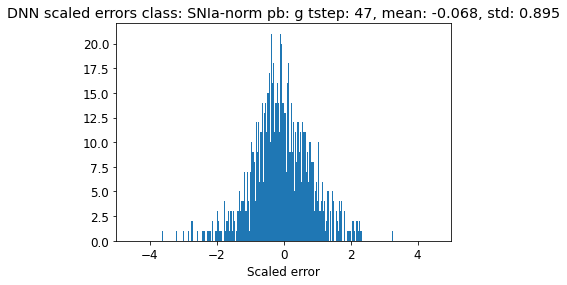

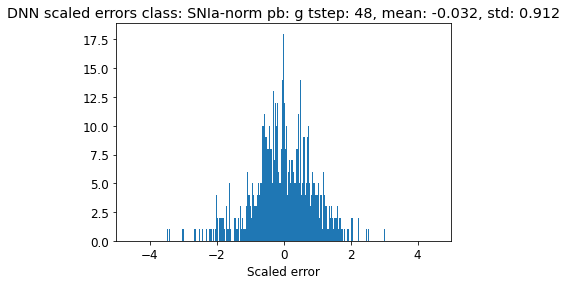

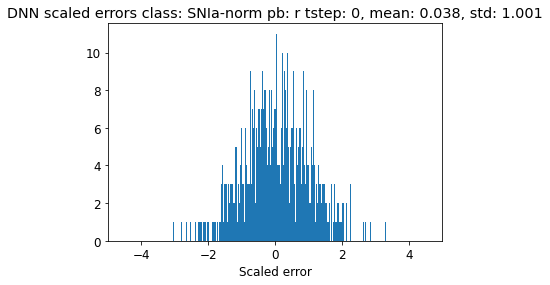

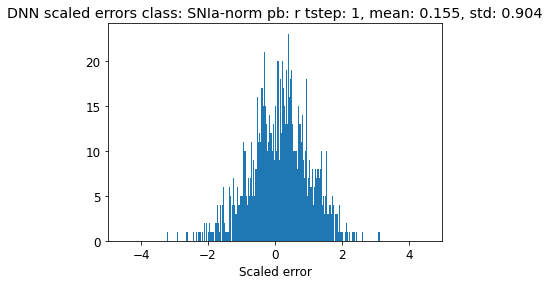

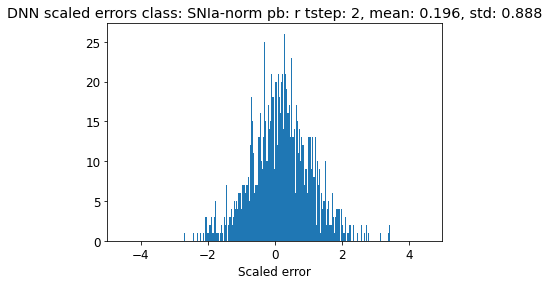

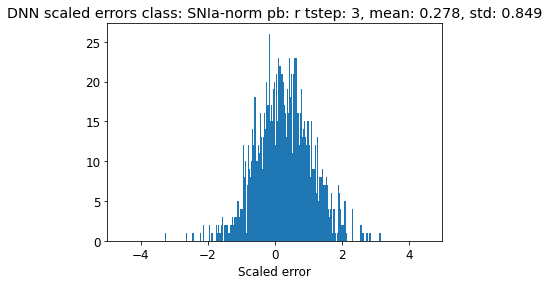

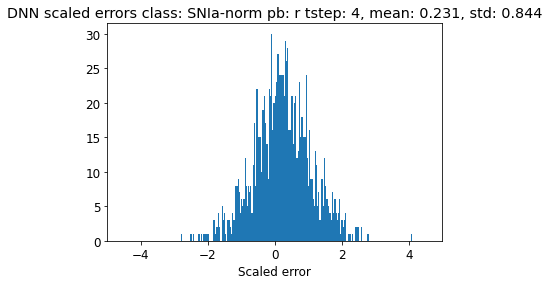

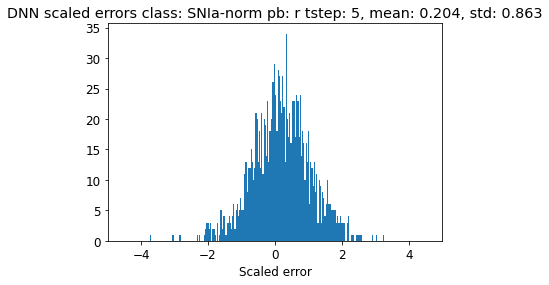

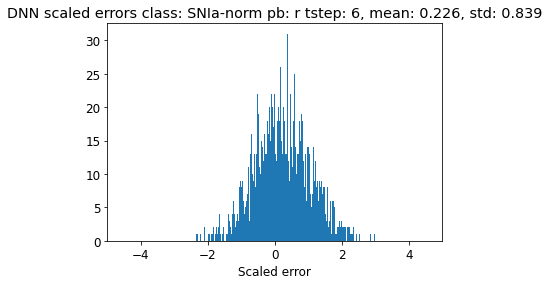

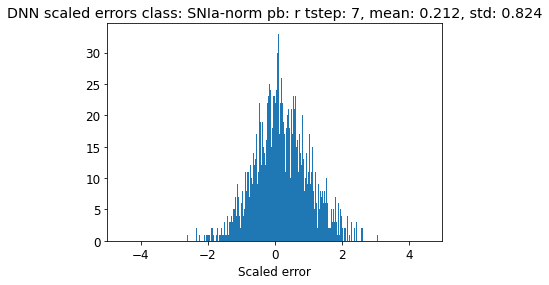

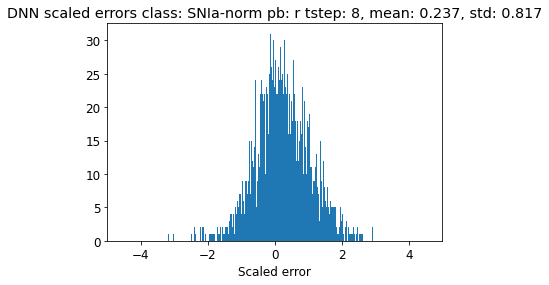

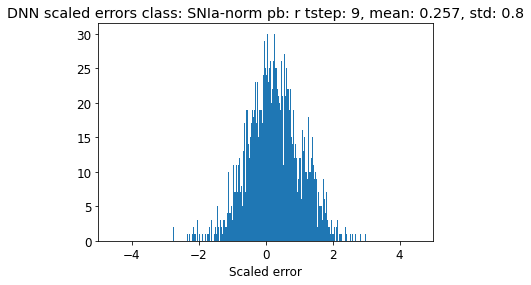

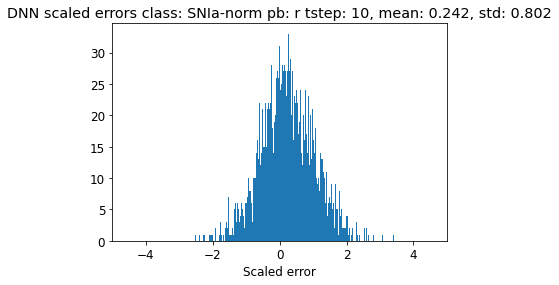

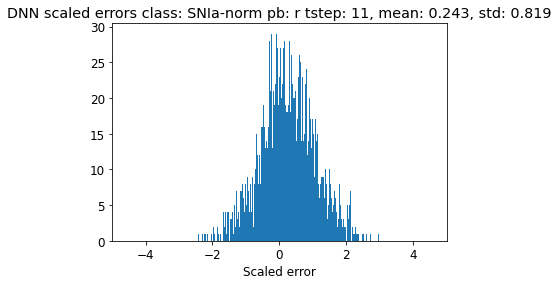

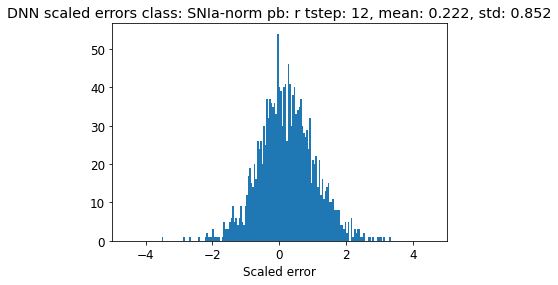

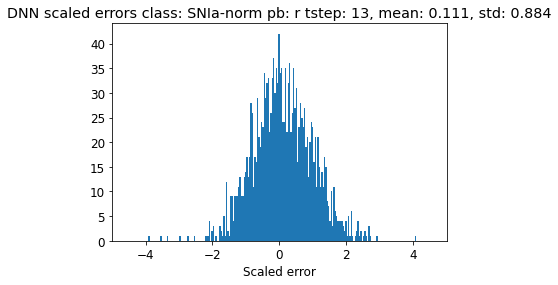

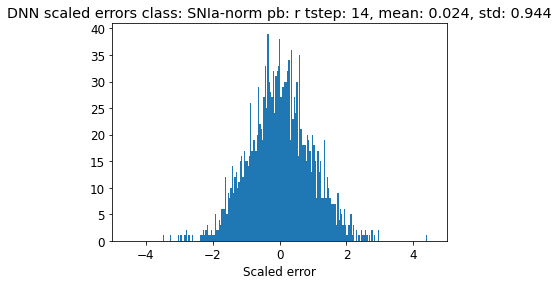

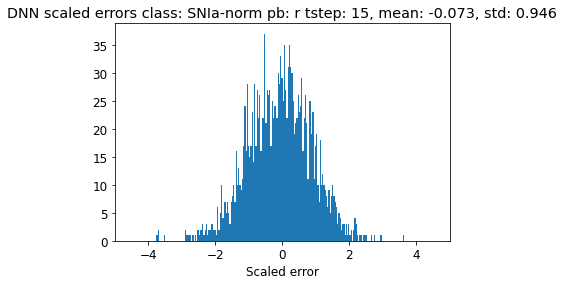

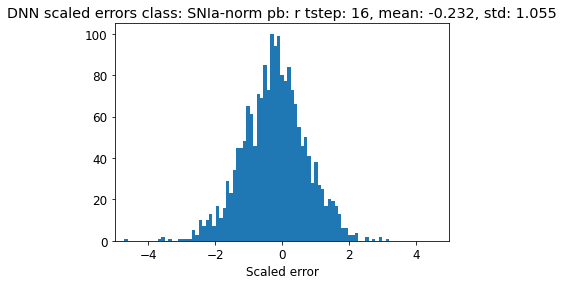

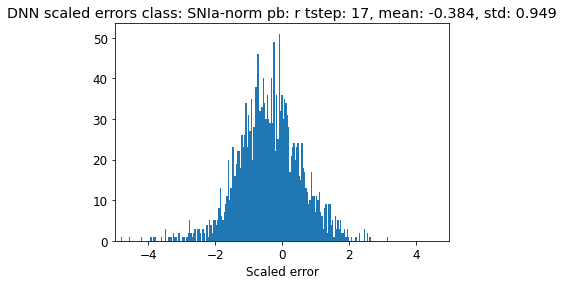

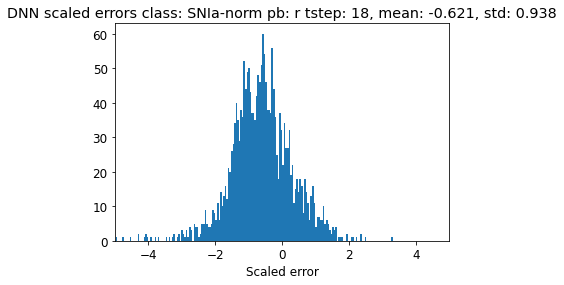

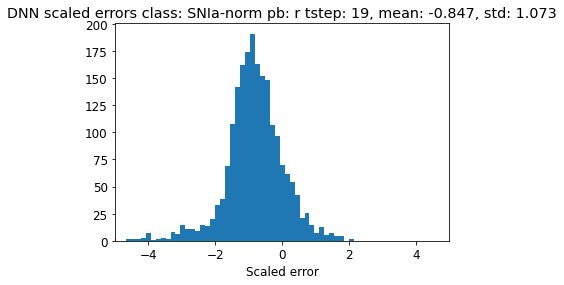

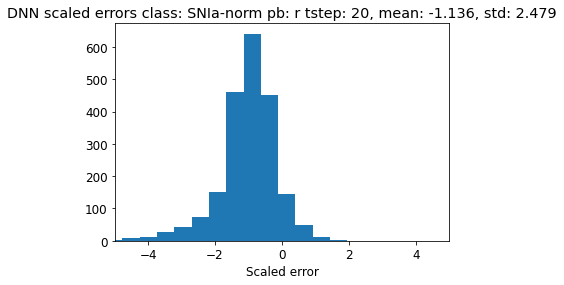

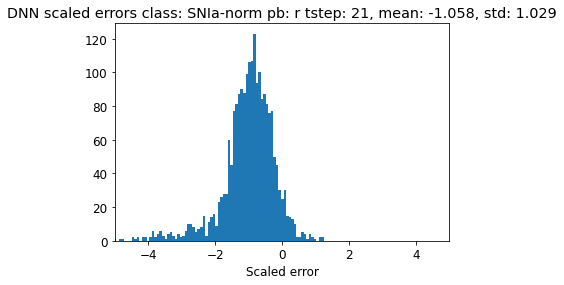

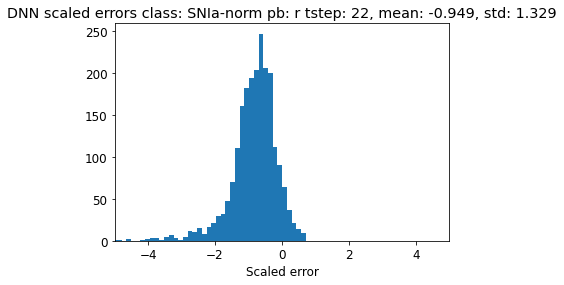

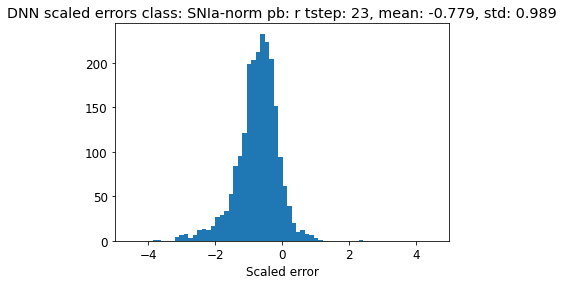

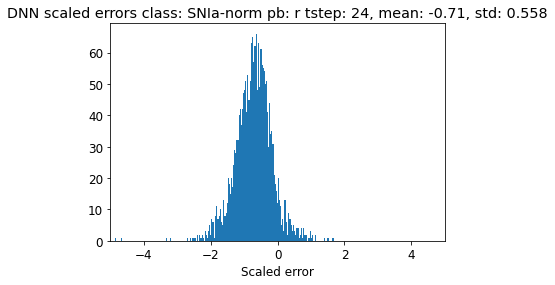

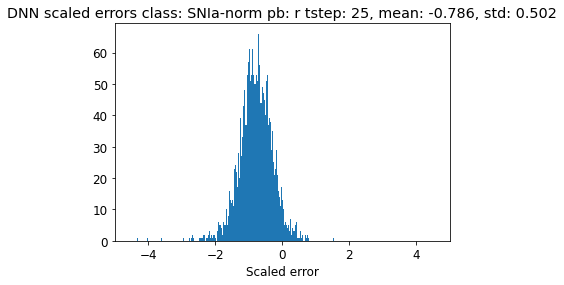

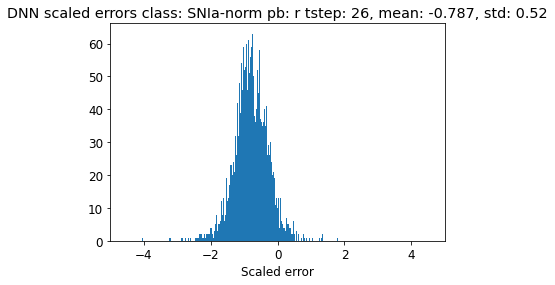

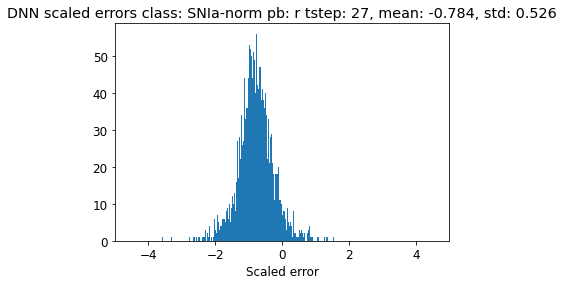

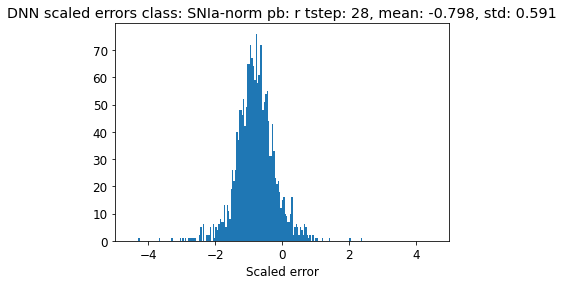

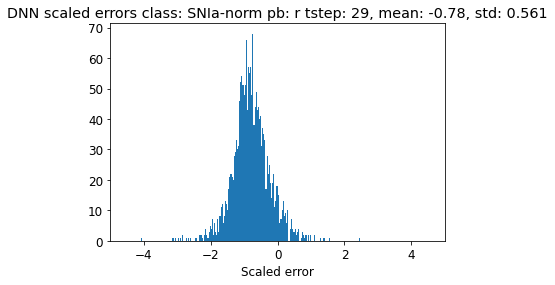

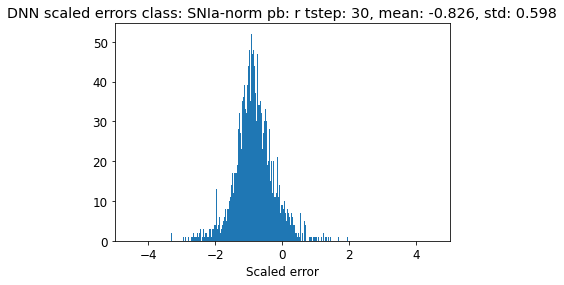

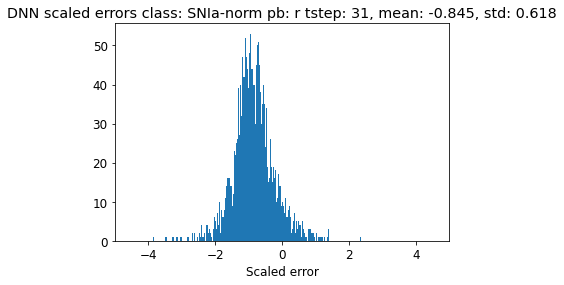

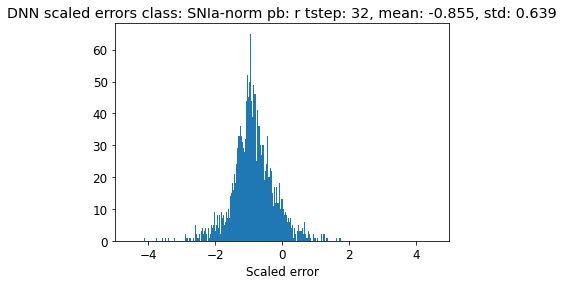

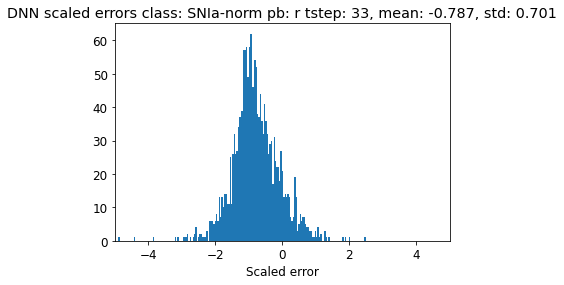

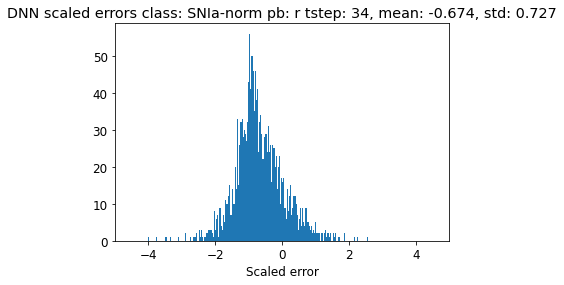

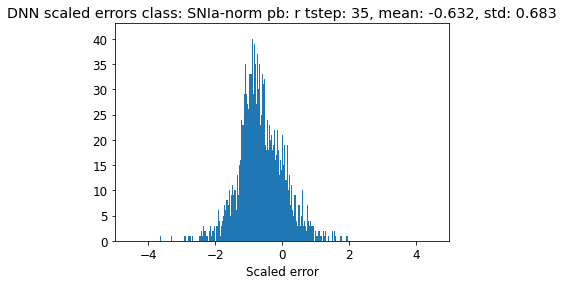

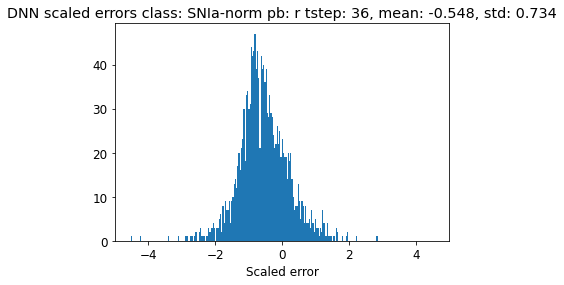

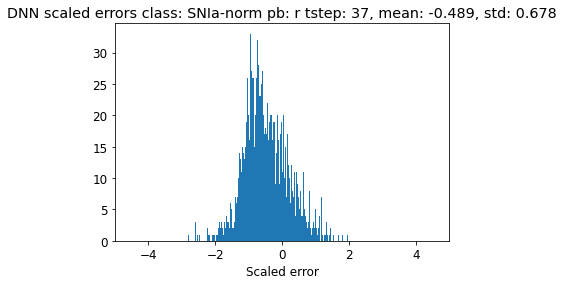

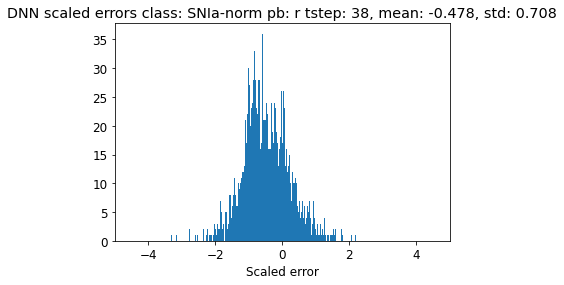

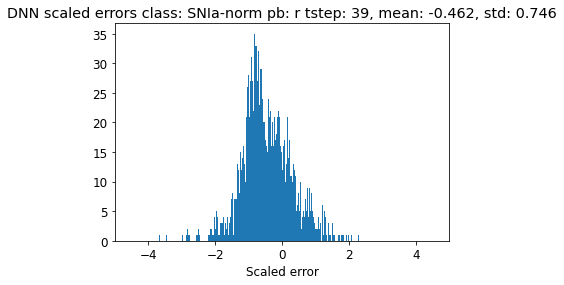

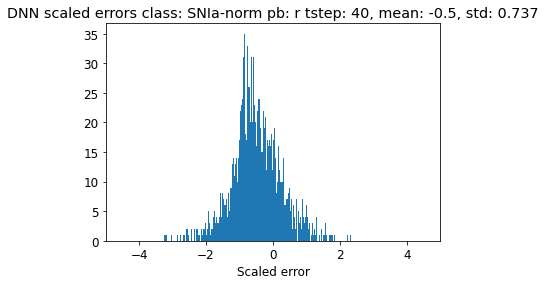

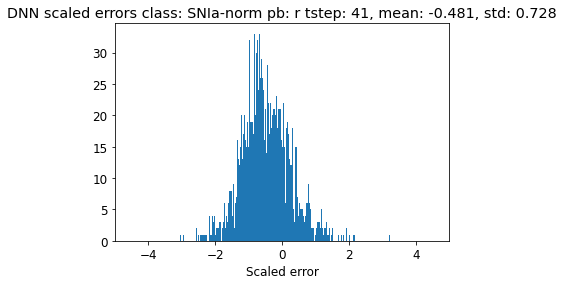

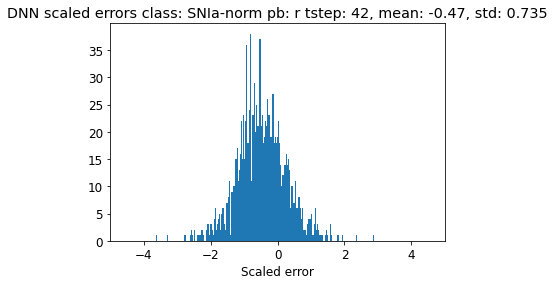

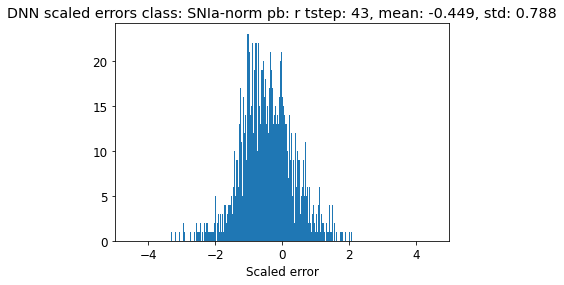

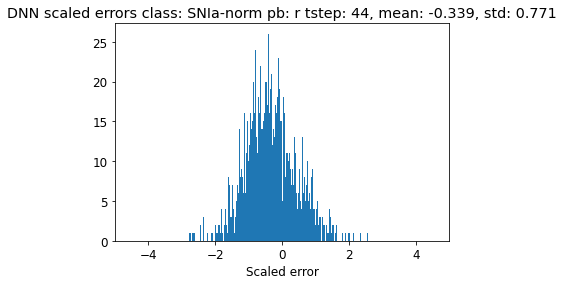

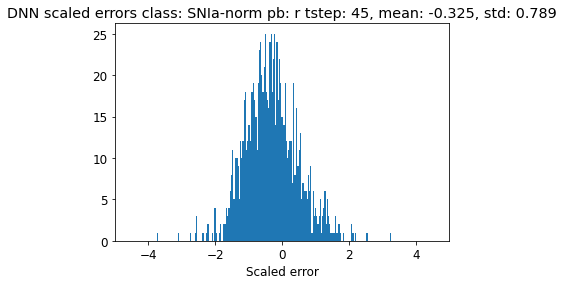

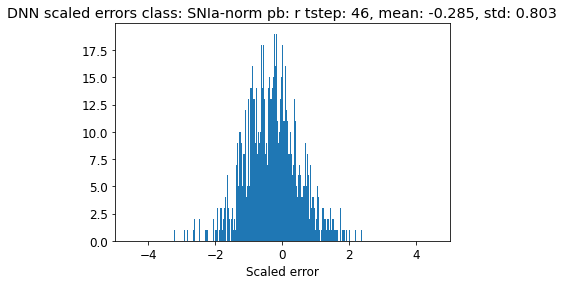

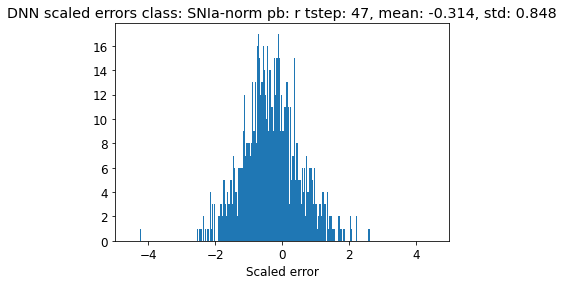

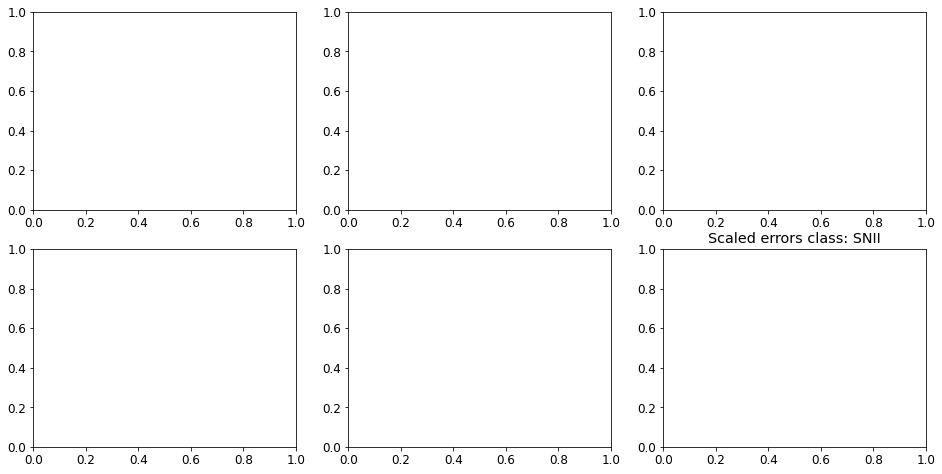

In [31]:
# Combine above three cells
font = {'family': 'normal',
        'size': 12}
matplotlib.rc('font', **font)

for class_num in class_nums_all:    
    class_nums = (class_num,)
    class_name = sntypes_map[class_num]
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(16,8))
    plt.title(f"Scaled errors class: {class_name}")
    for bayesian in [True, False]: 
        nn_architecture_change = f"mcdropout_TCN_{'probabilistic_' if probabilistic else ''}bayesian{bayesian}_uncertainties{use_uncertainties}_predictfuture{npred}point_normalised{normalise}_dropout{dropout_rate}_units{nunits}_batchsize{batch_size}_lr{learning_rate}"
   
        preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
        X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
        timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
            preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, only_use_objids=objids_to_use[class_num])
        
        fig_dir = os.path.join(os.path.join(SCRIPT_DIR, '..', 'plots'), "model_{}_ci{}_ns{}_c{}".format(otherchange, contextual_info, nsamples, class_nums))
        model, model_name = train_model(X_train, X_test, y_train, y_test, yerr_train, yerr_test, fig_dir=fig_dir, epochs=train_epochs, retrain=retrain, passbands=passbands, model_change=nn_architecture_change, reframe=reframe_problem, probabilistic=probabilistic, train_from_last_stop=train_from_last_stop, batch_size=batch_size, nunits=nunits, use_uncertainties=use_uncertainties, bayesian=bayesian, dropout_rate=dropout_rate, learning_rate=learning_rate)

        # Analyse predictive uncertainties
        nobjects, ntimesteps, nfeatures = y_test.shape
        npassbands = len(passbands)
        sntypes_map = helpers.get_sntypes()

        if bayesian:
            sampled_ypred = []
            sampled_ystd = []
            draws = []
            ns = 100
            for i in range(ns):
                sampled_yhat = model(X_test)
                sampled_ypred.append(np.asarray(sampled_yhat.mean()))
                sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
                draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
            plot_mean_ypred = np.mean(np.array(draws), axis=0)
            plot_sigma_ypred = np.std(np.array(draws), axis=0)
        else:
            yhat = model(X_test)
            plot_mean_ypred = np.asarray(yhat.mean())
            plot_sigma_ypred = np.asarray(yhat.stddev())


        # Analyse predictive uncertainties continued...
        import imageio
        print("Measured, predicted shapes:", y_test.shape, plot_mean_ypred.shape, plot_sigma_ypred.shape)

        maskzeros = (y_test[:,:,2:] == 0)
        scaled_error = (plot_mean_ypred - y_test[:,:,:2])/np.sqrt(plot_sigma_ypred**2 + y_test[:,:,2:]**2)
        scaled_error[maskzeros] = None
        
        plot_times = np.arange(-67, 80, 3)

        mean_scalederrors = {'g': [], 'r': []}
        std_scalederrors = {'g': [], 'r': []}
        for pbidx, pb in enumerate(passbands):
            images = []
            for tstep, t in enumerate(plot_times):
                tstep_mask = (np.abs(timesX_test[:,1:] - t)) < 1.5  # Mask time steps closest to t. No more than one index per object
                x = scaled_error[:,:,pbidx][tstep_mask]
                xmean = np.nanmean(x)
                xstd = np.nanstd(x)
                fig_t = plt.figure()
                ax_t = plt.gca()
                ax_t.set_title(f"DNN scaled errors class: {class_name} pb: {pb} tstep: {tstep}, mean: {round(xmean,3)}, std: {round(xstd,3)}")
                ax_t.hist(x, bins=200)
                ax_t.set_xlim(-5,5)
                ax_t.set_xlabel("Scaled error")
                filename = f"gif_images/{class_name}_DNN_scaled_errors_{pb}_{tstep}_mcdropout{bayesian}.png"
                fig_t.savefig(filename)
                # plt.show()
                print(f"class: {class_name}, pb: {pb}, tstep: {tstep}, Mean: {xmean}, std: {xstd}")
                mean_scalederrors[pb].append(xmean)
                std_scalederrors[pb].append(xstd)
                images.append(imageio.imread(filename))
            imageio.mimsave(f'{class_name}_DNN_scaled_errors_{pb}_mcdropout{bayesian}.gif', images)
            # plt.figure()
            axs[pbidx,0].set_title(f"Scaled errors mean, {class_name} {pb}")
            axs[pbidx,0].plot(plot_times, mean_scalederrors[pb], label=('bayesian' if bayesian else 'not bayesian'))
            axs[pbidx,0].axhline(y=0, color='k', linestyle='--')
            axs[pbidx,0].set_xlabel("Time in days")
            axs[pbidx,0].set_ylabel("Scaled error mean")
            axs[pbidx,0].legend()
            # plt.savefig(f"{class_num}_DNN Scaled errors mean, passband {pb}.pdf")
            # plt.figure()
            axs[pbidx,1].set_title(f"Scaled errors std, {class_name} {pb}")
            axs[pbidx,1].plot(plot_times, std_scalederrors[pb], label=('bayesian' if bayesian else 'not bayesian'))
            axs[pbidx,1].axhline(y=1, color='k', linestyle='--')
            axs[pbidx,1].set_xlabel("Time in days")
            axs[pbidx,1].set_ylabel("Scaled error std")
            axs[pbidx,1].legend()
            # plt.savefig(f"{class_num}_DNN Scaled errors std, passband {pb}.pdf")

            print("Scaled_error shape:", scaled_error.shape, scaled_error.flatten().shape)
            # plt.figure()
            axs[pbidx,2].set_title(f"Scaled errors all times, {class_name}, passband {pb}")
            axs[pbidx,2].hist(scaled_error[:,:,pbidx].flatten(), bins=500, alpha=0.5, label=('bayesian' if bayesian else 'not bayesian'));
            axs[pbidx,2].set_xlim(-5,5)
            axs[pbidx,2].set_xlabel("Scaled error")
            axs[pbidx,2].legend()
            # plt.savefig(f"{class_num}_DNN Scaled errors, passband {pb}.pdf")
            print(f"Mean: {np.mean(scaled_error.flatten())}, std: {np.std(scaled_error.flatten())}")
    plt.tight_layout()
    fig.savefig(f"{class_name}_DNN_Scaled_errors.pdf")
    # plt.show()
    plt.close()

In [15]:
! ls "plots/model_linear_spline_with_unc_inXandy_ci()_ns1_c(1,)/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001.hdf5"

'plots/model_linear_spline_with_unc_inXandy_ci()_ns1_c(1,)/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001.hdf5'


Getting predictions for model 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


Getting predictions for model 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


Getting predictions for model 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


Getting predictions for model 51


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


Getting predictions for model 60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


Getting predictions for model 64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


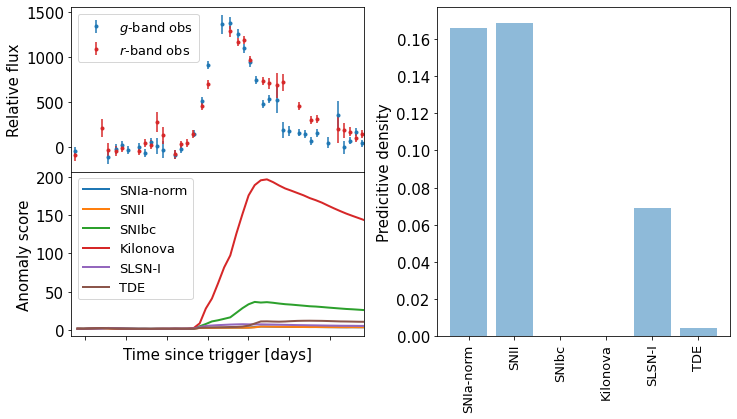

In [16]:
# Paper plot
npassbands = len(passbands)
class_nums = (1,)
preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
    preparearrays.make_training_set(class_nums, nsamples, otherchange, nprocesses, extrapolate_gp, reframe=reframe_problem, npred=npred, normalise=normalise, use_uncertainties=use_uncertainties, train_size=0.99)

paper_objid = "1_18581367"#"1_124486590"  # '1_132490785'
paper_idx = int(np.where(objids_test == paper_objid)[0])
lc_classnum = int(paper_objid.split('_')[0])
light_curves = {}
light_curves[lc_classnum] = get_data(get_data_func=get_data_func, class_num=lc_classnum, data_dir=data_dir,
                                  save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                  nprocesses=nprocesses, redo=False, calculate_t0=False)
lc = light_curves[lc_classnum][paper_objid]
sntypes_map = helpers.get_sntypes()

fig = plt.figure(figsize=(10.4, 6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(223, sharex=ax1)
ax3 = plt.subplot(122)
for pbidx, pb in enumerate(passbands):
    pbmask = lc['passband'] == pb
    ax1.errorbar(lc[pbmask]['time'].data, lc[pbmask]['flux'].data, yerr=lc[pbmask]['fluxErr'].data, fmt='.', color=COLPB[pb], label=f'${pb}$-band obs')

ascores = []
ascores_nll = []
model_classnums = (1,2,3,51,60,64)
model_classnames = [sntypes_map[c] for c in model_classnums]
for model_classnum in model_classnums:
    print(f"Getting predictions for model {model_classnum}")
    model_filepath = f"plots/model_linear_spline_with_unc_inXandy_ci()_ns1_c({model_classnum},)/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001/keras_model_epochs10000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.4_units30_batchsize64_lr0.001.hdf5"
    model = load_model(model_filepath, custom_objects={'loss': negloglike_with_error, 'TCN': TCN})
    sampled_ypred = []
    sampled_ystd = []
    draws = []
    ns = 100
    for i in range(ns):
        sampled_yhat = model(X_test)
        sampled_ypred.append(np.asarray(sampled_yhat.mean()))
        sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
        draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
    plot_mean_ypred = np.mean(np.array(draws), axis=0)
    plot_sigma_ypred = np.std(np.array(draws), axis=0)

    for pbidx, pb in enumerate(passbands):
        pbmask = lc['passband'] == pb
        # for drawidx in range(ns):
        #     ax1.plot(timesX_test[paper_idx][1:], sampled_ypred[drawidx][paper_idx][:, pbidx], color=COLPB[pb], alpha=0.05)
        # ax1.plot(timesX_test[paper_idx][1:], np.median(np.array(sampled_ypred)[:, paper_idx, :, pbidx], axis=0), label=f'${pb}$-band pred', color=COLPB[pb], linewidth=2, linestyle='-')  # median

    chi2 = 0
    negloglike = 0
    maskzeros = True
    for pbidx in range(npassbands):
        yt = y_test[paper_idx, :, pbidx]
        yterr = yerr_test[paper_idx, :, pbidx]
        yp = plot_mean_ypred[paper_idx, :, pbidx]
        yperr = plot_sigma_ypred[paper_idx, :, pbidx]
        maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
        chi2 += ((yp - yt)/yterr)**2
        negloglike += 0.5 * (yp - yt)**2 / (yterr*2 + yperr**2) + 0.5*np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
    chi2 = chi2[maskzeros] / npassbands
    negloglike = negloglike[maskzeros]/npassbands
    chi2cumsum = np.cumsum(chi2)/np.arange(1, len(chi2)+1)
    negloglikecumsum = np.cumsum(negloglike)/np.arange(1, len(negloglike)+1)
    ascores.append(sum(chi2)/len(chi2))
    ascores_nll.append(sum(negloglike)/len(negloglike))
    # ax1.text(0.05, 0.95, f"$\chi^2 = {round(max(chi2), 3)}$", horizontalalignment='left', verticalalignment='center', transform=fig.transFigure) #1
    # ax1.text(0.05, 0.95, f"{class_name}", transform=fig.transFigure) #1
    # ax1.legend(frameon=True, fontsize=13, loc='upper left')
    ax2.plot(timesX_test[paper_idx][1:][maskzeros], chi2cumsum, lw=2, label=sntypes_map[model_classnum]) #2
    # ax2.text(0.05, 0.95, f"$\chi^2 = {round(np.sum(chi2)/len(yt), 3)}$", horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes) #2

barplt = ax3.bar(np.arange(len(model_classnums)), np.exp(-np.array(ascores)/2), color='tab:blue', alpha=0.5)
ax3.set_xticks(np.arange(len(model_classnums)), model_classnames)
ax3.set_xticklabels(np.insert(model_classnames, 0, 0), rotation=90)

ax1.legend(fontsize=13)
ax2.legend(fontsize=13)
ax1.axes.xaxis.set_ticklabels([])
ax1.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='x', labelsize=15) #2
ax2.tick_params(axis='y', labelsize=15) #2
ax3.tick_params(axis='x', labelsize=13) #2
ax3.tick_params(axis='y', labelsize=15) #2
ax2.set_xlim(-67, 77)
# ax1.set_ylim((-300, 2400))
ax1.set_ylabel("Relative flux", fontsize=15)
ax2.set_xlabel("Time since trigger [days]", fontsize=15) #2
ax2.set_ylabel("Anomaly score", fontsize=15) #2
ax3.set_ylabel("Predicitive density", fontsize=15) #2
plt.tight_layout()
fig.subplots_adjust(hspace=0) #2
plt.savefig(f"DNN_model_fitting-{paper_objid}_comparemodels.pdf") #2
plt.show()
plt.close()



In [17]:
# ax1.plot(timesX_test[paper_idx][1:][-npred:], sampled_ypred[drawidx][paper_idx][:, pbidx], color=COLPB[pb], alpha=0.05)
# timesX_test[paper_idx][1:].shape
# sampled_ypred[drawidx][paper_idx][:, pbidx]

In [32]:
#@title Similarity matrix function definitions
from transomaly import helpers
sntypes_map = helpers.get_sntypes()

def get_similarity_matrix(class_nums, model_filepaths, preparearrays, nprocesses, extrapolate_gp, nsamples, ignore_class_names_test_on=[]):
    X_train, X_test, y_train, y_test, Xerr_train, Xerr_test, yerr_train, yerr_test, \
    timesX_train, timesX_test, labels_train, labels_test, objids_train, objids_test = \
        preparearrays.make_training_set(class_nums=class_nums, nsamples=1, otherchange='getKnAndOtherTypes', nprocesses=nprocesses, extrapolate_gp=extrapolate_gp, reframe=False, npred=1, normalise=normalise, use_uncertainties=use_uncertainties)

    similarity_matrix = {}
    similarity_matrix_chi2 = {}
    anomaly_scoreslist_chi2_dict = {}
    anomaly_scores_nll_wpredunc_dict = {}
    anomaly_score_chi2_wpredunc_dict = {}
    anomaly_score_nll_withoutpredunc_dict = {}
    for class_name, model_filepath in model_filepaths.items():
        print(class_name)

        if not os.path.exists(model_filepath):
            print("No model found at", model_filepath)
            continue

        saved_scores_fp = os.path.join(os.path.dirname(model_filepath), f'similarity_scores_10000-0.2_{class_nums}_saveallmetrics.json')
  
        if os.path.exists(saved_scores_fp):
            print("Using saved similarity scores")
            with open(saved_scores_fp, 'r') as fp:
                similarity_score = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'r') as fp:
                similarity_score_chi2 = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scoreslist_chi2'), 'r') as fp:
                anomaly_scoreslist_chi2 = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scores_nll_wpredunc'), 'r') as fp:
                anomaly_scores_nll_wpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scores_chi2_withpredunc'), 'r') as fp:
                anomaly_scores_chi2_withpredunc = json.load(fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scores_nll_withoutpredunc'), 'r') as fp:
                anomaly_scores_nll_withoutpredunc = json.load(fp)
        else:
            print("Saving similarity scores...")
            model = load_model(model_filepath, custom_objects={'loss': negloglike_with_error(), 'TCN': TCN})
            similarity_score, similarity_score_chi2, anomaly_scoreslist_chi2, anomaly_scores_nll_wpredunc, anomaly_scores_chi2_withpredunc, anomaly_scores_nll_withoutpredunc = similarity_metric(model, X_test, y_test, yerr_test, labels_test,
                                                                       objids_test, nsamples)
            with open(saved_scores_fp, 'w') as fp:
                json.dump(similarity_score, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'similarity_scores_chi2_'), 'w') as fp:
                json.dump(similarity_score_chi2, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scoreslist_chi2'), 'w') as fp:
                json.dump(anomaly_scoreslist_chi2, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scores_nll_wpredunc'), 'w') as fp:
                json.dump(anomaly_scores_nll_wpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scores_chi2_withpredunc'), 'w') as fp:
                json.dump(anomaly_scores_chi2_withpredunc, fp)
            with open(saved_scores_fp.replace('similarity_scores_', 'anomaly_scores_nll_withoutpredunc'), 'w') as fp:
                json.dump(anomaly_scores_nll_withoutpredunc, fp)

        similarity_matrix[class_name] = similarity_score
        similarity_matrix_chi2[class_name] = similarity_score_chi2
        anomaly_scoreslist_chi2_dict[class_name] = anomaly_scoreslist_chi2
        anomaly_scores_nll_wpredunc_dict[class_name] = anomaly_scores_nll_wpredunc
        anomaly_score_chi2_wpredunc_dict[class_name] = anomaly_scores_chi2_withpredunc
        anomaly_score_nll_withoutpredunc_dict[class_name] = anomaly_scores_nll_withoutpredunc

    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix_chi2 = pd.DataFrame(similarity_matrix_chi2)

    similarity_matrix.to_csv('DNN_similarity_matrix.csv')
    similarity_matrix_chi2.to_csv('DNN_similarity_matrix_chi2.csv')

    print(similarity_matrix)

    similarity_matrix = similarity_matrix.drop(ignore_class_names_test_on)

    similarity_matrix_chi2 = similarity_matrix_chi2.reindex([sntypes_map[c] for c in class_nums]
)

    return similarity_matrix, similarity_matrix_chi2, anomaly_scoreslist_chi2_dict, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict


def similarity_metric(model, X_test, y_test, yerr_test, labels_test, objids_test, nsamples):
    nobjects, ntimesteps, npassbands = X_test.shape
    npassbands = 2

    sampled_ypred = []
    sampled_ystd = []
    draws = []
    ns = 100
    for drawidx in range(ns):
        sampled_yhat = model(X_test)
        sampled_ypred.append(np.asarray(sampled_yhat.mean()))
        sampled_ystd.append(np.asarray(sampled_yhat.stddev()))
        draws.append(np.random.normal(sampled_yhat.mean(), sampled_yhat.stddev()))
    y_pred_mean = np.mean(np.array(draws), axis=0)
    y_pred_sigma = np.std(np.array(draws), axis=0)
    y_pred_draws = np.array(draws)
    y_pred_median = np.median(y_pred_draws, axis=0)
    
    class_nums = np.unique(labels_test)
    sntypes_map = helpers.get_sntypes()
    class_names = [sntypes_map[class_num] for class_num in class_nums]

    anomaly_scores = {key: [] for key in class_names}
    anomaly_scores_chi2 = {key: [] for key in class_names}
    anomaly_score_chi2_withpredunc =  {key: [] for key in class_names}
    anomaly_score_nll_withoutpredunc = {key: [] for key in class_names}
    for idx in range(nobjects):
        sidx = idx * nsamples  # Assumes like samples are in order

        # Get anomaly scores
        chi2_samples = []
        like_samples = []
        negloglike_samples = []
        maskzeros = []
        for s in range(nsamples):
            npb = 0
            chi2 = 0
            like = 0
            negloglike = 0
            chi2_with_predunc = 0
            negloglike_without_predunc = 0
            maskzeros = True
            for pbidx in range(npassbands):
                yt = y_test[sidx+s, :, pbidx]
                yterr = yerr_test[sidx+s, :, pbidx]
                yp = y_pred_mean[sidx+s, :, pbidx]
                yperr = y_pred_sigma[sidx+s, :, pbidx]
                maskzeros = ((yterr != 0) * (np.isfinite(yterr))) & maskzeros
                try:
                    chi2 += ((yp - yt)/yterr)**2
                    like += np.exp(-0.5*(yp-yt)**2 / (yterr**2+yperr**2)) * (2*np.pi*(yterr**2+yperr**2))**-0.5
                    negloglike += 0.5 * (yp - yt)**2 / (yterr*2 + yperr**2) + 0.5 *np.log(yterr**2 + yperr**2) + 0.5*np.log(2*np.pi)
                    chi2_with_predunc += (yp - yt)**2 / (yterr*2 + yperr**2)
                    negloglike_without_predunc += 0.5 * (yp - yt)**2 / (yterr*2) + 0.5 *np.log(yterr**2) + 0.5*np.log(2*np.pi)
                    npb += 1
                except ValueError as e:
                    print(f"Failed chi2 object {objids_test[sidx + s]}", e)
            if not np.any(maskzeros):
                continue
            chi2 = chi2[maskzeros] / npb
            like = like[maskzeros] / npb
            negloglike = negloglike[maskzeros] / npb
            chi2_with_predunc = chi2_with_predunc[maskzeros] / npb
            negloglike_without_predunc = negloglike_without_predunc[maskzeros] / npb
            chi2_samples.append(chi2)
            like_samples.append(like)
            negloglike_samples.append(negloglike)
        if len(chi2_samples) == 0:
            continue
        anomaly_score_samples = np.array(negloglike_samples)
        anomaly_score_samples_chi2 = np.array(chi2_samples)
        anomaly_score_mean = np.mean(anomaly_score_samples, axis=0)
        anomaly_score_mean_chi2 = np.mean(anomaly_score_samples_chi2, axis=0)

        anomaly_score_max = np.nanmean(anomaly_score_mean)
        anomaly_score_max_chi2 = np.nanmean(anomaly_score_mean_chi2)

        class_name = sntypes_map[labels_test[sidx]]
        anomaly_scores[class_name].append(anomaly_score_max)
        anomaly_scores_chi2[class_name].append(anomaly_score_max_chi2)
        anomaly_score_chi2_withpredunc[class_name].append(np.nanmean(chi2_with_predunc))
        anomaly_score_nll_withoutpredunc[class_name].append(np.nanmean(negloglike_without_predunc))

    similarity_score = {key: [] for key in class_names}
    similarity_score_chi2 = {key: [] for key in class_names}
    for c in class_names:
        similarity_score[c] = np.median(anomaly_scores[c])
        similarity_score_chi2[c] = np.median(anomaly_scores_chi2[c])

    return similarity_score, similarity_score_chi2, anomaly_scores_chi2, anomaly_scores, anomaly_score_chi2_withpredunc, anomaly_score_nll_withoutpredunc


def plot_similarity_matrix(similarity_matrix):
    font = {'family': 'normal',
            'size': 36}
    matplotlib.rc('font', **font)

    xrange, yrange = similarity_matrix.shape
    similarity_matrix = similarity_matrix.T
    # similarity_matrix = similarity_matrix[
    #     ['SNIa', 'SNIa-x', 'SNII', 'SNIbc', 'SLSN-I', 'TDE', 'AGN', 'SNIIn', 'Ia-91bg', 'CART', 'TDE', 'PISN',
    #      'Kilonova']]
    xlabels = similarity_matrix.columns.values
    ylabels = similarity_matrix.index.values
    
    sntypes_map = helpers.get_sntypes()
    ylabels = [sntypes_map[ylabel] for ylabel in ylabels]

    minval = 0
    maxval = min(8, similarity_matrix.values.max())
    plt.figure(figsize=(15,12))
    im = plt.imshow(similarity_matrix, cmap=plt.cm.RdBu_r, vmin=minval, vmax=maxval)#, norm=colors.LogNorm())

    cb =  plt.colorbar(im, fraction=0.028, pad=0.04)
    # cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=27)
    plt.xticks(np.arange(xrange), xlabels, rotation=90, fontsize=27)
    plt.yticks(np.arange(yrange), ylabels, fontsize=27)

    thresh_q3 = 0.75 * maxval
    thresh_q1 = 0.25 * maxval
    for i in range(xrange):
        for j in range(yrange):
            c = similarity_matrix.iloc[j, i]
            if c > 100:
                cell_text = f"{c:.0f}"
            elif c > 10:
                cell_text = f"{c:.1f}"
            else:
                cell_text = f"{c:.2f}"
            plt.text(i, j, cell_text, va='center', ha='center', fontsize=24, color="white" if c < thresh_q1 or c > thresh_q3 else "black",)

    plt.ylabel('Training set')
    plt.xlabel('Testing set')
    plt.tight_layout()
    print("Saving matrix plot...")
    plt.savefig("similarity_matrix_epochs10000dpout0.2_cumsum_moretestclasses.pdf")

1
Using saved similarity scores
2
Using saved similarity scores
3
Using saved similarity scores
51
Using saved similarity scores
60
Using saved similarity scores
64
Using saved similarity scores
                  1          2          3         51        60        64
SNIa-norm   8.697855   7.356201   8.237835  6.680001  6.632161  6.912849
SNII        8.798932   7.352355   8.310291  6.736034  6.667555  6.916787
SNIbc       8.613805   7.321255   8.187333  6.627328  6.609745  6.975950
Kilonova   14.766966  10.117410  13.008071  6.570050  8.257725  8.567895
SLSN-I      7.551089   6.938513   7.340753  7.272801  6.506270  6.861096
PISN        6.871080   6.482130   6.601641  7.362667  6.201252  6.866925
ILOT        7.159819   6.633896   6.958831  7.235578  6.212090  6.710488
CART        8.766627   7.333024   8.230311  6.678850  6.633641  7.012830
TDE         8.035324   7.067533   7.773986  7.028106  6.644115  6.660438
uLens-BSR  10.924844   9.082295   9.862309  8.853177  8.263218  8.818121
Sa

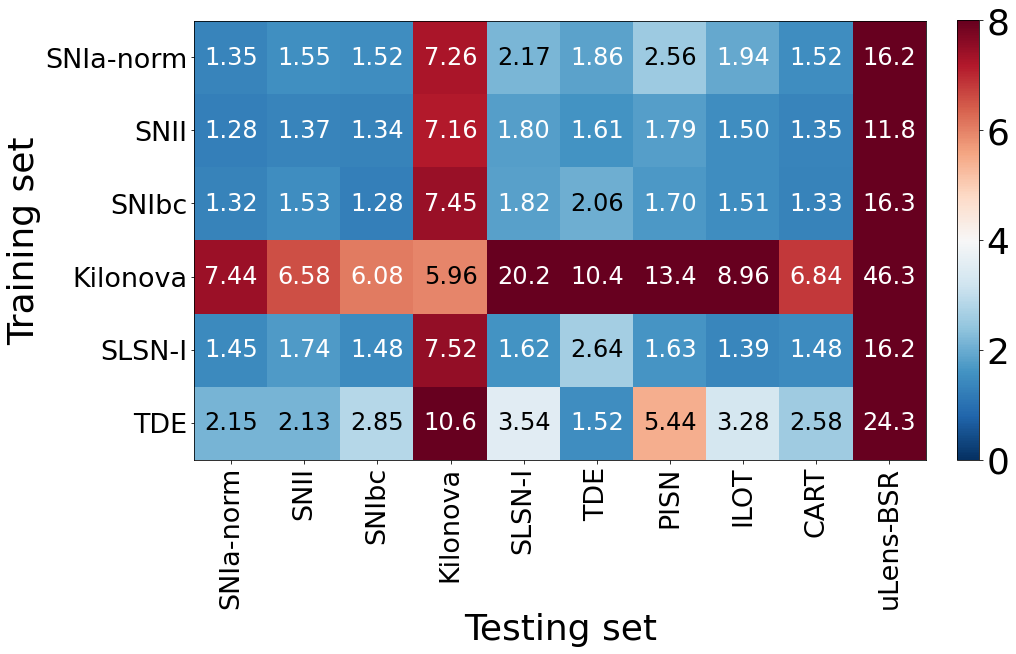

In [33]:
#@title # Plot similarity matrix
preparearrays = PrepareTrainingSetArrays(passbands, contextual_info, data_dir, save_dir, training_set_dir, redo, get_data_func, use_gp_interp)
otherchange = 'linear_spline_with_unc_inXandy'#"using_only_goodobjectsw20datapoints"  # linear_spline_with_unc_inXandy
train_epochs = 10000 #2001 # 10000

class_nums = [1, 2, 3, 51, 60, 64, 61, 62, 63, 90]#, 92]
model_filepaths = {}

model_filepaths[1]  = f'plots/model_{otherchange}_ci()_ns1_c(1,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[2]  = f'plots/model_{otherchange}_ci()_ns1_c(2,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[3]  = f'plots/model_{otherchange}_ci()_ns1_c(3,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[51] = f'plots/model_{otherchange}_ci()_ns1_c(51,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[60] = f'plots/model_{otherchange}_ci()_ns1_c(60,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'
model_filepaths[64] = f'plots/model_{otherchange}_ci()_ns1_c(64,)/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001/keras_model_epochs{train_epochs}_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5'


similarity_matrix, similarity_matrix_chi2, anomaly_scoreslist_chi2_dict, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict = get_similarity_matrix(class_nums, model_filepaths, preparearrays, nprocesses=None, extrapolate_gp=False, nsamples=1, ignore_class_names_test_on=[])
plot_similarity_matrix(similarity_matrix_chi2)
# plot_similarity_scatter_plot(similarity_matrix)

Using model SNIa-norm


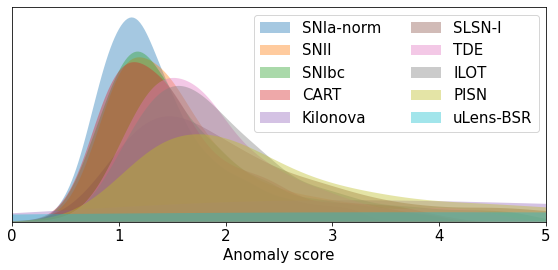

Using model SNII


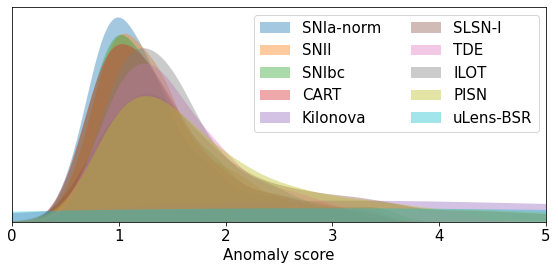

Using model SNIbc


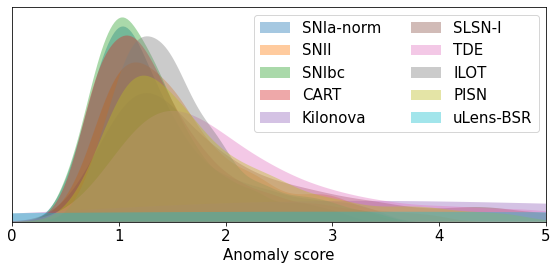

Using model Kilonova


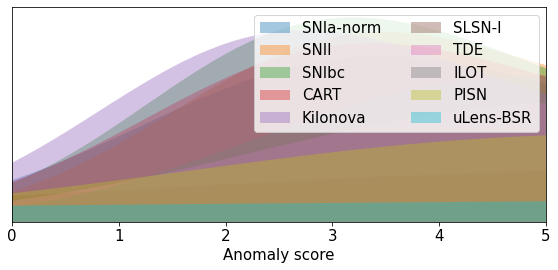

Using model SLSN-I


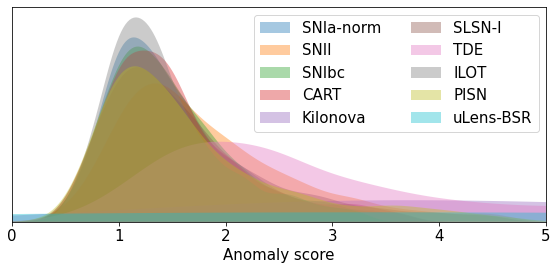

Using model TDE


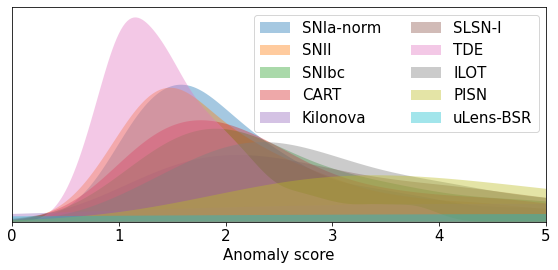

In [20]:
from transomaly import helpers
sntypes_map = helpers.get_sntypes()
from scipy import stats

font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)


for modelnum in anomaly_scoreslist_chi2_dict.keys():
    print("Using model", sntypes_map[modelnum])
    plt.figure(f"Model {modelnum}", figsize=(8,4))
    for cname in  ['SNIa-norm', 'SNII', 'SNIbc','CART', 'Kilonova', 'SLSN-I', 'TDE', 'ILOT', 'PISN', 'uLens-BSR']:#anomaly_scoreslist_chi2_dict[modelnum].keys():
        # Remove outliers
        ascores = np.array(anomaly_scoreslist_chi2_dict[modelnum][cname])

        d = abs(ascores - np.median(ascores))
        mad = np.median(d)
        ascores_removed_outliers = ascores[d < 5*mad]
        # print(len(ascores), len(ascores_removed_outliers))
        nbins = int((ascores_removed_outliers.max() - ascores_removed_outliers.min())*50/5)
        # plt.hist(ascores_removed_outliers, bins=nbins, label=cname, alpha=0.4)#, range=(0,5))
        kde = stats.gaussian_kde(ascores_removed_outliers)
        x = np.linspace(0, 20, 1000)
        plt.fill_between(x, kde(x), alpha=0.4, label=cname)
        plt.legend()
    plt.yticks([])
    plt.legend(ncol=2)
    plt.xlabel("Anomaly score")
    plt.xlim(0,5)
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.savefig(f"Anomaly_scores_distribution_DNN_{modelnum}.pdf")
    plt.show()


SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE


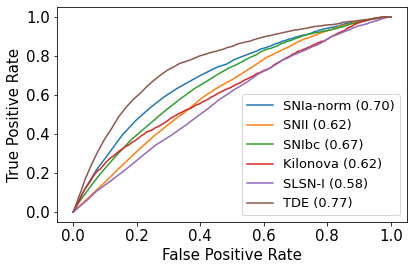

In [21]:
font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

# Make ROC curves
anomaly_scoreslist_chi2_dict
model_classes = [1, 2, 3, 51, 60, 64]

test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']

model_transient = 'SNIa-norm'
test_classes.remove(model_transient)
anomalous_transients =  test_classes  #['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # 

tsteps = 0.1
for model_transient in model_classes:
    model_classname = sntypes_map[model_transient]
    print(model_classname)
    metric_names = ['$\chi^2$ without $\sigma_{pred}$', "negloglike with $\sigma_{pred}$", '$\chi^2$ with $\sigma_{pred}$', "negloglike without $\sigma_{pred}$"]
    for m, metric_dict in enumerate([anomaly_scoreslist_chi2_dict]):#, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict]):
        tprs = []
        fprs = []
        thresholds = []
        for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
            # if threshold % 100 == 0: print(model_transient, threshold)
            tp = np.count_nonzero(metric_dict[model_transient][model_classname] < threshold)
            fn = np.count_nonzero(metric_dict[model_transient][model_classname] > threshold)
            fp = sum([np.count_nonzero(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
            tn = sum([np.count_nonzero(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
            tpr = tp / (tp+fn)  # sensitivity
            fpr = fp / (fp+tn)  # 1 - specificity
        #     print(tp, fn, fp, tn, tpr, fpr)
            tprs.append(tpr)
            fprs.append(fpr)
            thresholds.append(threshold)

        auc = round(np.trapz(tprs, fprs), 3)
        plt.plot(fprs, tprs, label=f"{model_classname} ({auc:.2f})") # f"{metric_names[m]} ({auc})")

        # for i, threshold in enumerate(thresholds):
        #     if threshold % 10 == 0:
        #         plt.annotate(thresholds[i], # this is the text
        #                     (fprs[i],tprs[i]), # this is the point to label
        #                     textcoords="offset points", # how to position the text
        #                     xytext=(0,10), # distance from text to points (x,y)
        #                     ha='center') # horizontal alignment can be left, right or center

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig(f"DNN_ROC_curve_chi2_withalltestclasses_tstep{tsteps}_renamedtrueanomaly.pdf")  # withanomalousclassesonly# plt.savefig(f"DNN_compare_metrics_onlyanomalousclasses_{model_classname}.pdf")
plt.show()

In [22]:
%%timeit
tp = sum(metric_dict[model_transient][model_classname] < threshold)
fn = sum(metric_dict[model_transient][model_classname] > threshold)
fp = sum([sum(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
tn = sum([sum(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
# tp = np.count_nonzero(metric_dict[model_transient][model_classname] < threshold)
# fn = np.count_nonzero(metric_dict[model_transient][model_classname] > threshold)
# fp = sum([np.count_nonzero(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
# tn = sum([np.count_nonzero(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])

10 loops, best of 3: 84.5 ms per loop


SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE


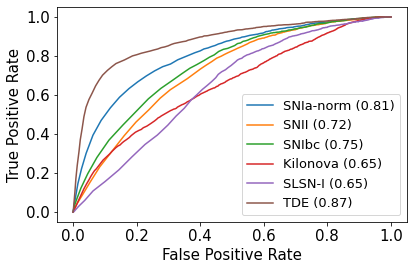

In [23]:
font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

# Make ROC curves
anomaly_scoreslist_chi2_dict
model_classes = [1, 2, 3, 51, 60, 64]

test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']

model_transient = 'SNIa-norm'
test_classes.remove(model_transient)
anomalous_transients =  ['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # test_classes  #['Kilonova', 'PISN', 'ILOT', 'uLens-BSR'] # 

tsteps = 0.1
for model_transient in model_classes:
    model_classname = sntypes_map[model_transient]
    print(model_classname)
    metric_names = ['$\chi^2$ without $\sigma_{pred}$', "negloglike with $\sigma_{pred}$", '$\chi^2$ with $\sigma_{pred}$', "negloglike without $\sigma_{pred}$"]
    for m, metric_dict in enumerate([anomaly_scoreslist_chi2_dict]):#, anomaly_scores_nll_wpredunc_dict, anomaly_score_chi2_wpredunc_dict, anomaly_score_nll_withoutpredunc_dict]):
        tprs = []
        fprs = []
        thresholds = []
        for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
            tp = np.count_nonzero(metric_dict[model_transient][model_classname] < threshold)
            fn = np.count_nonzero(metric_dict[model_transient][model_classname] > threshold)
            fp = sum([np.count_nonzero(metric_dict[model_transient][anomaly] < threshold) for anomaly in anomalous_transients])
            tn = sum([np.count_nonzero(metric_dict[model_transient][anomaly] > threshold) for anomaly in anomalous_transients])
            tpr = tp / (tp+fn)  # sensitivity
            fpr = fp / (fp+tn)  # 1 - specificity
        #     print(tp, fn, fp, tn, tpr, fpr)
            tprs.append(tpr)
            fprs.append(fpr)
            thresholds.append(threshold)

        auc = round(np.trapz(tprs, fprs), 3)
        plt.plot(fprs, tprs, label=f"{model_classname} ({auc:.2f})") # f"{metric_names[m]} ({auc})")

        # for i, threshold in enumerate(thresholds):
        #     if threshold % 10 == 0:
        #         plt.annotate(thresholds[i], # this is the text
        #                     (fprs[i],tprs[i]), # this is the point to label
        #                     textcoords="offset points", # how to position the text
        #                     xytext=(0,10), # distance from text to points (x,y)
        #                     ha='center') # horizontal alignment can be left, right or center

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig(f"DNN_ROC_curve_chi2_withanomalousclassesonly_tstep{tsteps}_renamedtrueanomaly.pdf")  # withanomalousclassesonly# plt.savefig(f"DNN_compare_metrics_onlyanomalousclasses_{model_classname}.pdf")
plt.show()

SNIa-norm
SNII
SNIbc
Kilonova
SLSN-I
TDE
CART
PISN
ILOT
uLens-BSR


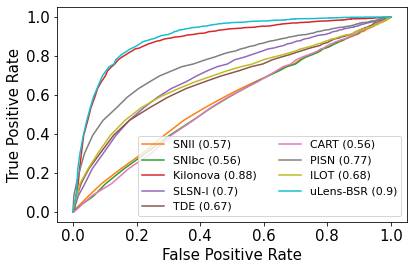

SNII
SNIa-norm
SNIbc


KeyboardInterrupt: ignored

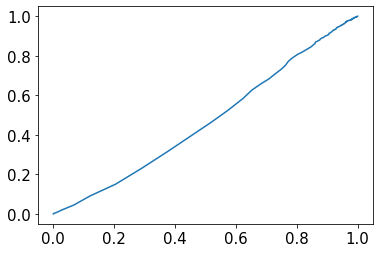

In [34]:
font = {'family': 'normal', 'size': 15}
matplotlib.rc('font', **font)

# Make ROC curves
model_classes = [1, 2, 3, 51, 60, 64]

class_colors = {'SNIa-norm': 'tab:blue', 'SNII': 'tab:orange', 'SNIbc': 'tab:green',
                'Kilonova': 'tab:red', 'SLSN-I': 'tab:purple', 'TDE': 'tab:brown', 
                'CART': 'tab:pink', 'PISN': 'tab:grey', 'ILOT': '#bcbd22', 'uLens-BSR': '#17becf'}

model_transient = 'SNIa-norm'


tsteps = 0.1
for model_transient in model_classes:
    model_classname = sntypes_map[model_transient]
    print(model_classname)
    test_classes = ['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'TDE', 'CART', 'PISN', 'ILOT', 'uLens-BSR']
    test_classes.remove(model_classname)
    for anomaly in test_classes:
        print(anomaly)
        tprs = []
        fprs = []
        thresholds = []
        for threshold in np.append(np.arange(0, 3000, tsteps), np.inf):
            tp = np.count_nonzero(anomaly_scoreslist_chi2_dict[model_transient][model_classname] < threshold)  # was tp. 
            fn = np.count_nonzero(anomaly_scoreslist_chi2_dict[model_transient][model_classname] > threshold)  # was fn. False anomaly 
            fp = np.count_nonzero(anomaly_scoreslist_chi2_dict[model_transient][anomaly] < threshold)  # was fp
            tn = np.count_nonzero(anomaly_scoreslist_chi2_dict[model_transient][anomaly] > threshold)  # was tn. True anomaly 
            tpr = tp / (tp+fn)  # sensitivity
            fpr = fp / (fp+tn)  # 1 - specificity
        #     print(tp, fn, fp, tn, tpr, fpr)
            tprs.append(tpr)
            fprs.append(fpr)
            thresholds.append(threshold)

        auc = round(np.trapz(tprs, fprs), 2)
        plt.plot(fprs, tprs, label=f"{anomaly} ({auc})", color=class_colors[anomaly])

    # for i, threshold in enumerate(thresholds):
    #     if threshold in [1,2,3,4,5,6,7,8,9,10]:
    #         plt.annotate(int(thresholds[i]), # this is the text
    #                     (fprs[i],tprs[i]), # this is the point to label
    #                     textcoords="offset points", # how to position the text
    #                     xytext=(0,10), # distance from text to points (x,y)
    #                     ha='center') # horizontal alignment can be left, right or center

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=11, ncol=2, loc='lower right')
    plt.tight_layout()
    plt.savefig(f"DNN_ROC_curve_chi2_{model_transient}vseachtestclass_tstep{tsteps}_renamedtrueanomaly.pdf")  #withanomalousclassesonly
    plt.show()

In [ ]:
# Plot TPR vs 

In [25]:
anomaly_scoreslist_chi2_dict[1].keys()

dict_keys(['SNIa-norm', 'SNII', 'SNIbc', 'Kilonova', 'SLSN-I', 'PISN', 'ILOT', 'CART', 'TDE', 'uLens-BSR'])

In [26]:
left! ls plots/'model_linear_spline_with_unc_inXandy_ci()_ns1_c(1,)'/'keras_model_epochs5000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001'/'keras_model_epochs5000_mcdropout_TCN_probabilistic_bayesianTrue_uncertaintiesTrue_predictfuture1point_normalisedFalse_dropout0.2_units30_batchsize64_lr0.001.hdf5
'


SyntaxError: ignored

In [ ]:
for i in range(len(X_train[0])):
  print(X_test[0][i], y_test[0][i])

In [ ]:
light_curves = {}
gp_fits = {}
for classnum in np.unique(labels_test):
    print(f"Getting lightcurves for class:{classnum}")
    light_curves[classnum] = get_data(get_data_func=get_data_func, class_num=classnum, data_dir=data_dir,
                                      save_dir=save_dir, passbands=passbands, known_redshift=known_redshift,
                                      nprocesses=nprocesses, redo=False, calculate_t0=False)
gp_fits[classnum] = save_gps(light_curves, save_dir, classnum, passbands, plot=False,
                          nprocesses=nprocesses, redo=False, extrapolate=extrapolate_gp)

In [ ]:
# yhat = model(X_train[0:1])
# y_pred = np.asarray(yhat.mean())
# y_pred_std = np.asarray(yhat.stddev())
# print(X_train[0], y_pred)
print(X_train.shape)

In [ ]:
# loss=lambda y, rv_y: -rv_y.log_prob(y)
# model.set_weights(old_weights)
model.compile(loss=negloglike_with_error(), optimizer='adam')
model.evaluate(X_test, y_test)
# Default model

In [ ]:
! git config --global user.email "daniel.muthukrishna@gmail.com"
! git config --global user.name "daniel-muthukrishna"
# ! git diff
! git stash
! git pull

In [ ]:
# # not-Bayesian:
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_1 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1D)     (None, 49, 30)            90        
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            150       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1D)            (None, 49, 30)            1830      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_1 (TimeDist (None, 49, 4)             124       
# _________________________________________________________________
# distribution_lambda_1 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 13,174
# Trainable params: 13,174
# Non-trainable params: 0

# # Bayesian network:
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# masking_3 (Masking)          (None, 49, 2)             0         
# _________________________________________________________________
# matching_conv1D (Conv1DFlipo (None, 49, 30)            150       
# _________________________________________________________________
# activation_14 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            270       
# _________________________________________________________________
# activation_12 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_8 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_13 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_9 (Spatial (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_17 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_15 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_10 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_16 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_11 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_20 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_18 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_12 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_19 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_13 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# matching_identity (Lambda)   (None, 49, 30)            0         
# _________________________________________________________________
# activation_23 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_0 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_21 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_14 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# conv1D_1 (Conv1DFlipout)     (None, 49, 30)            3630      
# _________________________________________________________________
# activation_22 (Activation)   (None, 49, 30)            0         
# _________________________________________________________________
# spatial_dropout1d_15 (Spatia (None, 49, 30)            0         
# _________________________________________________________________
# lambda_1 (Lambda)            multiple                  0         
# _________________________________________________________________
# time_distributed_3 (TimeDist (None, 49, 4)             244       
# _________________________________________________________________
# distribution_lambda_3 (Distr ((None, 49, 2), (None, 49 0         
# =================================================================
# Total params: 26,074
# Trainable params: 26,074
# Non-trainable params: 0

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()